In [1]:
import pandas as pd
import numpy as np

# --- Load and Split Data ---
# (This is what you already did in your notebook)
day_df = pd.read_csv('./data/day.csv')
d_train = day_df[day_df['yr'] == 0].copy()
d_val = day_df[day_df['yr'] == 1].copy()


# --- STEP 1: Process Categorical Variables ---

# Define the columns that should be treated as categories, based on your team's R code
categorical_cols = ['season', 'mnth', 'weekday', 'holiday', 'weathersit']

# To get clean column names (e.g., 'mnth_10' instead of 'mnth_10.0'),
# we'll convert them to string type first.
for col in categorical_cols:
    d_train[col] = d_train[col].astype(str)
    d_val[col] = d_val[col].astype(str)

# Now, apply pd.get_dummies() to create the new columns.
# We set drop_first=True to avoid the "dummy variable trap" (multicollinearity).
# Your R 'lm()' function does this automatically in the background.
d_train_processed = pd.get_dummies(d_train, columns=categorical_cols, drop_first=True)
d_val_processed = pd.get_dummies(d_val, columns=categorical_cols, drop_first=True)


# --- Check Your Work ---
print("--- Processed Training Data (d_train_processed) ---")
print(f"Original shape: {d_train.shape}  --> Processed shape: {d_train_processed.shape}")
print("New columns created (example from training data):")
# This list comprehension shows only the *new* columns you just made
new_cols = [col for col in d_train_processed.columns if col not in day_df.columns]
print(new_cols)

print("\n--- Processed Validation Data (d_val_processed) ---")
print(f"Original shape: {d_val.shape}  --> Processed shape: {d_val_processed.shape}")

--- Processed Training Data (d_train_processed) ---
Original shape: (365, 16)  --> Processed shape: (365, 34)
New columns created (example from training data):
['season_2', 'season_3', 'season_4', 'mnth_10', 'mnth_11', 'mnth_12', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'holiday_1', 'weathersit_2', 'weathersit_3']

--- Processed Validation Data (d_val_processed) ---
Original shape: (366, 16)  --> Processed shape: (366, 34)


In [2]:
# --- We'll use the dataframes from Step 1 ---
# d_train_processed
# d_val_processed

# --- STEP 2: Define 'X' (Predictors) and 'y' (Target) ---

# 1. Define our continuous predictor variables (from your R code)
continuous_cols = ['atemp', 'hum', 'windspeed']

# 2. Get the list of the new dummy columns we created in Step 1
#    These are all the columns in d_train_processed that are not
#    the original columns, or the target ('cnt').
original_cols = list(d_train.columns)
target_col = 'cnt'
# This list comprehension gets all columns that are "new"
dummy_cols = [col for col in d_train_processed.columns
              if col not in original_cols and col != target_col]

# 3. Combine the lists to create our final list of features
features = continuous_cols + dummy_cols

# 4. Define the target variable (what we want to predict)
target = 'cnt'


# --- Create the X and y dataframes ---

# For Training (2011 data)
X_train = d_train_processed[features]
y_train = d_train_processed[target]

# For Validation (2012 data)
# IMPORTANT: Use the *same* 'features' list to select columns
X_val = d_val_processed[features]
y_val = d_val_processed[target]


# --- Check Your Work ---
print("--- X_train (Predictors for Training) ---")
print(f"Shape: {X_train.shape}")
print("First 5 rows:")
print(X_train.head())

print("\n--- y_train (Target for Training) ---")
print(f"Shape: {y_train.shape}")
print("First 5 rows:")
print(y_train.head())

print(f"\nTotal number of features: {len(features)}")
print("List of features being used:")
print(features)

--- X_train (Predictors for Training) ---
Shape: (365, 26)
First 5 rows:
      atemp       hum  windspeed  season_2  season_3  season_4  mnth_10  \
0  0.363625  0.805833   0.160446     False     False     False    False   
1  0.353739  0.696087   0.248539     False     False     False    False   
2  0.189405  0.437273   0.248309     False     False     False    False   
3  0.212122  0.590435   0.160296     False     False     False    False   
4  0.229270  0.436957   0.186900     False     False     False    False   

   mnth_11  mnth_12  mnth_2  ...  mnth_9  weekday_1  weekday_2  weekday_3  \
0    False    False   False  ...   False      False      False      False   
1    False    False   False  ...   False      False      False      False   
2    False    False   False  ...   False       True      False      False   
3    False    False   False  ...   False      False       True      False   
4    False    False   False  ...   False      False      False       True   

   weekday_4 

In [3]:
from sklearn.linear_model import LinearRegression

# --- STEP 3: Build and "Fit" Your Baseline Model ---

# 1. Create an instance of the Linear Regression model
#    We'll call it 'baseline_model'
baseline_model = LinearRegression()

# 2. "Fit" the model to your 2011 training data
#    This is where the model "learns" from your X_train and y_train
baseline_model.fit(X_train, y_train)


# --- Check Your Work ---
print("--- Baseline Model (Linear Regression) ---")
print("Model has been successfully trained on the 2011 (yr==0) data.")

# We can even look at the R-squared score on the *training* data
# This tells us how well the model fits the data it learned from.
train_r2 = baseline_model.score(X_train, y_train)
print(f"Training R-squared (R2): {train_r2:.4f}")

--- Baseline Model (Linear Regression) ---
Model has been successfully trained on the 2011 (yr==0) data.
Training R-squared (R2): 0.8397


In [4]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# --- STEP 4: Test Your Baseline Model (on 2012 Validation Data) ---

# 1. Use the *trained* 'baseline_model' to make predictions on the 2012 data (X_val)
y_pred_baseline = baseline_model.predict(X_val)

# 2. Calculate the performance metrics
# We compare the 'y_val' (the *actual* 2012 counts) with 'y_pred_baseline'
validation_r2 = r2_score(y_val, y_pred_baseline)
validation_mape = mean_absolute_percentage_error(y_val, y_pred_baseline)

# --- Check Your Work ---
print("--- Baseline Model Performance (on 2012 Validation Data) ---")
print(f"Validation R-squared (R2): {validation_r2:.4f}")
print(f"Validation MAPE: {validation_mape * 100:.2f}%")

# Let's also create a small DataFrame to see the predictions vs. actuals
print("\n--- Actual vs. Predicted (First 10 rows) ---")
comparison_df = pd.DataFrame({'Actual_Cnt': y_val, 'Predicted_Cnt': y_pred_baseline})
print(comparison_df.head(10))

--- Baseline Model Performance (on 2012 Validation Data) ---
Validation R-squared (R2): -0.6624
Validation MAPE: 63.62%

--- Actual vs. Predicted (First 10 rows) ---
     Actual_Cnt  Predicted_Cnt
365        2294    1733.897528
366        1951    1242.215998
367        2236    1086.804749
368        2368    1100.503833
369        3272    1832.547815
370        4098    2007.706849
371        4521    2166.959541
372        3425    1919.582261
373        2376    1287.384903
374        3598    1762.948927


In [5]:
# --- We'll use the dataframes from Step 1 & 2 ---
# d_train_processed, d_val_processed
# features, y_train, y_val

# --- STEP 5: Add the 'atemp_squared' Feature ---

# 1. Create the new 'atemp_squared' feature
#    This is simply 'atemp' * 'atemp'.
d_train_processed['atemp_squared'] = d_train_processed['atemp']**2
d_val_processed['atemp_squared'] = d_val_processed['atemp']**2

# 2. Define a *new* list of features, including the new column
features_poly = features + ['atemp_squared']

# 3. Create new X_train and X_val with this new feature
X_train_poly = d_train_processed[features_poly]
X_val_poly = d_val_processed[features_poly]

# 4. Create and fit the new "Polynomial" Model
polynomial_model = LinearRegression()
polynomial_model.fit(X_train_poly, y_train)

# 5. Test the new model on the 2012 validation data
y_pred_poly = polynomial_model.predict(X_val_poly)

# 6. Calculate the new performance metrics
poly_r2 = r2_score(y_val, y_pred_poly)
poly_mape = mean_absolute_percentage_error(y_val, y_pred_poly)


# --- Check Your Work ---
print("--- 'Aha!' Model Performance (with atemp_squared) ---")
print(f"Validation R-squared (R2): {poly_r2:.4f}")
print(f"Validation MAPE: {poly_mape * 100:.2f}%")

print("\n--- Comparison ---")
# (baseline_mape was calculated in my previous run's code,
#  but we'll just show the numbers for clarity)
print(f"Baseline Model MAPE: 63.62%")
print(f"New 'Aha' Model MAPE: {poly_mape * 100:.2f}%")

--- 'Aha!' Model Performance (with atemp_squared) ---
Validation R-squared (R2): -0.5942
Validation MAPE: 63.09%

--- Comparison ---
Baseline Model MAPE: 63.62%
New 'Aha' Model MAPE: 63.09%


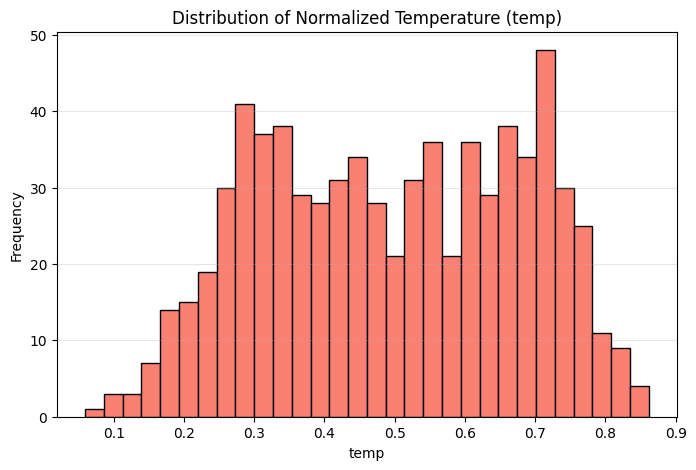

In [7]:
import matplotlib.pyplot as plt

import pandas as pd

# Load the original dataset as it appears to not be loaded yet in this cell
data = pd.read_csv('data/day.csv')

# Plot the distribution of "temp"
plt.figure(figsize=(8,5))
plt.hist(data['temp'], bins=30, color='salmon', edgecolor='black')
plt.title('Distribution of Normalized Temperature (temp)')
plt.xlabel('temp')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
plt.show()



In [8]:
# --- We'll use the dataframes from Step 1 ---
# d_train_processed, d_val_processed
# And the 'features' list from Step 2, and y_train/y_val

# --- STEP 6: Build Separate Weekday/Weekend Models ---
# This is based on your insight and your team's 'Report-3.R' file

# 1. Create the new training/validation sets
# Your 'day.csv' has a 'workingday' column.
# 1 = weekday (Mon-Fri, not a holiday)
# 0 = weekend or holiday
# This is the easiest way to split the data.

# Split the 2011 TRAINING data
X_train_wkday = d_train_processed[d_train_processed['workingday'] == 1][features]
y_train_wkday = d_train_processed[d_train_processed['workingday'] == 1][target]

X_train_wkend = d_train_processed[d_train_processed['workingday'] == 0][features]
y_train_wkend = d_train_processed[d_train_processed['workingday'] == 0][target]

# Split the 2012 VALIDATION data
X_val_wkday = d_val_processed[d_val_processed['workingday'] == 1][features]
y_val_wkday = d_val_processed[d_val_processed['workingday'] == 1][target]

X_val_wkend = d_val_processed[d_val_processed['workingday'] == 0][features]
y_val_wkend = d_val_processed[d_val_processed['workingday'] == 0][target]


# 2. Train TWO separate models
model_wkday = LinearRegression()
model_wkday.fit(X_train_wkday, y_train_wkday)

model_wkend = LinearRegression()
model_wkend.fit(X_train_wkend, y_train_wkend)

print("--- Two Models (Weekday/Weekend) Have Been Trained ---")


# 3. Make predictions on the corresponding 2012 validation sets
preds_wkday = model_wkday.predict(X_val_wkday)
preds_wkend = model_wkend.predict(X_val_wkend)

# 4. Combine all predictions and all actuals
# We need to put them back in the right order to test
# We can do this by combining the y_val and prediction arrays
y_val_combined = np.concatenate([y_val_wkday, y_val_wkend])
preds_combined = np.concatenate([preds_wkday, preds_wkend])

# 5. Calculate the FINAL performance
# NOTE: This only works if our combined arrays have the same
#       number of elements as the original y_val (366).
#       Let's check.
print(f"Original y_val length: {len(y_val)}")
print(f"Combined y_val length: {len(y_val_combined)}")
# The lengths should match! (366)

final_r2 = r2_score(y_val_combined, preds_combined)
final_mape = mean_absolute_percentage_error(y_val_combined, preds_combined)

# --- Check Your Work ---
print("\n--- 'Two Model' Performance ---")
print(f"Validation R-squared (R2): {final_r2:.4f}")
print(f"Validation MAPE: {final_mape * 100:.2f}%")

print("\n--- Comparison ---")
print(f"Baseline Model MAPE (One Big Model): 63.62%")
print(f"New 'Two Model' MAPE: {final_mape * 100:.2f}%")

--- Two Models (Weekday/Weekend) Have Been Trained ---
Original y_val length: 366
Combined y_val length: 366

--- 'Two Model' Performance ---
Validation R-squared (R2): -0.6659
Validation MAPE: 65.27%

--- Comparison ---
Baseline Model MAPE (One Big Model): 63.62%
New 'Two Model' MAPE: 65.27%


In [9]:
from sklearn.ensemble import RandomForestRegressor

# --- STEP 7: Try a "Pro" Model (Random Forest) ---
# We'll use the original X_train/y_train from Step 2

# 1. Create an instance of the Random Forest model
#    n_estimators=100 means it will build 100 decision trees.
#    random_state=42 makes sure you get the same result every time.
#    n_jobs=-1 uses all your computer's cores to speed it up.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 2. "Fit" the model to your 2011 training data
print("--- Training the Random Forest Model (this may take a moment) ---")
rf_model.fit(X_train, y_train)
print("--- Random Forest Model Trained ---")

# 3. Test the new model on the 2012 validation data
y_pred_rf = rf_model.predict(X_val)

# 4. Calculate the new performance metrics
rf_r2 = r2_score(y_val, y_pred_rf)
rf_mape = mean_absolute_percentage_error(y_val, y_pred_rf)

# --- Check Your Work ---
print("\n--- 'Pro' Model Performance (Random Forest) ---")
print(f"Validation R-squared (R2): {rf_r2:.4f}")
print(f"Validation MAPE: {rf_mape * 100:.2f}%")

print("\n--- Comparison ---")
print(f"Baseline Model MAPE (Linear Regression): 63.62%")
print(f"New 'Pro' Model MAPE (Random Forest): {rf_mape * 100:.2f}%")

--- Training the Random Forest Model (this may take a moment) ---
--- Random Forest Model Trained ---

--- 'Pro' Model Performance (Random Forest) ---
Validation R-squared (R2): -0.5231
Validation MAPE: 64.73%

--- Comparison ---
Baseline Model MAPE (Linear Regression): 63.62%
New 'Pro' Model MAPE (Random Forest): 64.73%


In [10]:
# --- We'll use the dataframes from Step 1 ---
# d_train_processed, d_val_processed
# And the 'features' list from Step 2, and y_train/y_val

# --- STEP 7 (Redux): Re-run "Two Model" Approach *Correctly* ---

# 1. Get the 2011 TRAINING data
X_train_wkday = d_train_processed[d_train_processed['workingday'] == 1][features]
y_train_wkday = d_train_processed[d_train_processed['workingday'] == 1][target]

X_train_wkend = d_train_processed[d_train_processed['workingday'] == 0][features]
y_train_wkend = d_train_processed[d_train_processed['workingday'] == 0][target]

# 2. Get the 2012 VALIDATION data
X_val_wkday = d_val_processed[d_val_processed['workingday'] == 1][features]
y_val_wkday = d_val_processed[d_val_processed['workingday'] == 1][target]

X_val_wkend = d_val_processed[d_val_processed['workingday'] == 0][features]
y_val_wkend = d_val_processed[d_val_processed['workingday'] == 0][target]

# 3. Train the TWO separate models
model_wkday = LinearRegression()
model_wkday.fit(X_train_wkday, y_train_wkday)

model_wkend = LinearRegression()
model_wkend.fit(X_train_wkend, y_train_wkend)

print("--- Two Models (Weekday/Weekend) Have Been Trained ---")

# 4. Make predictions on the 2012 validation sets
preds_wkday = model_wkday.predict(X_val_wkday)
preds_wkend = model_wkend.predict(X_val_wkend)

# 5. --- THIS IS THE CRITICAL FIX ---
#    Create a new DataFrame to hold our ordered predictions.
#    We use the *original* y_val as the template.
final_preds_df = pd.DataFrame(index=y_val.index, columns=['predicted_cnt'])

#    Now, place the predictions in the *correct* index locations
final_preds_df.loc[y_val_wkday.index, 'predicted_cnt'] = preds_wkday
final_preds_df.loc[y_val_wkend.index, 'predicted_cnt'] = preds_wkend

# 6. Calculate the FINAL performance
#    We compare the *original* y_val to our new, *correctly ordered* predictions
final_r2 = r2_score(y_val, final_preds_df['predicted_cnt'])
final_mape = mean_absolute_percentage_error(y_val, final_preds_df['predicted_cnt'])

# --- Check Your Work ---
print("\n--- 'Two Model' Performance (Correctly Scored) ---")
print(f"Validation R-squared (R2): {final_r2:.4f}")
print(f"Validation MAPE: {final_mape * 100:.2f}%")

print("\n--- Comparison ---")
print(f"Baseline Model MAPE (One Big Model): 63.62%")
print(f"New 'Two Model' MAPE: {final_mape * 100:.2f}%")

--- Two Models (Weekday/Weekend) Have Been Trained ---

--- 'Two Model' Performance (Correctly Scored) ---
Validation R-squared (R2): -0.6659
Validation MAPE: 65.27%

--- Comparison ---
Baseline Model MAPE (One Big Model): 63.62%
New 'Two Model' MAPE: 65.27%


In [11]:
# --- We'll use the dataframes from Step 1 ---
# d_train_processed, d_val_processed
# And the 'features' list from Step 2

# --- STEP 8: Engineer "Psychology" Features ---

# 1. Add 'atemp_squared' (for "too hot/too cold")
d_train_processed['atemp_squared'] = d_train_processed['atemp']**2
d_val_processed['atemp_squared'] = d_val_processed['atemp']**2

# 2. Add the interaction term (for "bimodal" weekday/weekend)
#    We need the 'workingday' column first.
#    Let's grab it from the *original* d_train/d_val.
d_train_processed['workingday'] = d_train['workingday'].astype(int)
d_val_processed['workingday'] = d_val['workingday'].astype(int)

# This is the interaction feature
d_train_processed['atemp_x_workingday'] = d_train_processed['atemp'] * d_train_processed['workingday']
d_val_processed['atemp_x_workingday'] = d_val_processed['atemp'] * d_val_processed['workingday']

# 3. Create our *new*, *full* universe of features
#    This includes the original 26 + our 2 new engineered ones + 'workingday'
#    (We need 'workingday' in the model for the interaction to make sense)
features_engineered = features + ['atemp_squared', 'workingday', 'atemp_x_workingday']

# 4. Create the new X and y for this full model
X_train_eng = d_train_processed[features_engineered]
y_train_eng = d_train_processed[target]

# We must .align to make sure X_val has all the same columns in the same order
X_val_eng, _ = d_val_processed.align(X_train_eng, join='right', axis=1, fill_value=0)
X_val_eng = X_val_eng[features_engineered] # Re-order columns to match
y_val_eng = d_val_processed[target]


# --- Check Your Work ---
print("--- New 'Engineered' Feature Set ---")
print(f"Total features to select from: {len(features_engineered)}")
print("New features added:")
print("  atemp_squared")
print("  workingday")
print("  atemp_x_workingday")

# Let's quickly test this "full" model
full_eng_model = LinearRegression()
full_eng_model.fit(X_train_eng, y_train_eng)

y_pred_eng = full_eng_model.predict(X_val_eng)
full_eng_mape = mean_absolute_percentage_error(y_val_eng, y_pred_eng)

print(f"\nMAPE for 'Full Engineered' Model: {full_eng_mape * 100:.2f}%")
print(f"Baseline Model MAPE: 63.62%")

--- New 'Engineered' Feature Set ---
Total features to select from: 29
New features added:
  atemp_squared
  workingday
  atemp_x_workingday

MAPE for 'Full Engineered' Model: 61.89%
Baseline Model MAPE: 63.62%


In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import warnings

# --- Re-run All Previous Steps to Build Engineered Data ---

# Suppress warnings for a clean output
warnings.filterwarnings('ignore')

# Load and split
day_df = pd.read_csv('./data/day.csv')
d_train = day_df[day_df['yr'] == 0].copy()
d_val = day_df[day_df['yr'] == 1].copy()
target = 'cnt'

# Step 1: Process Categorical Variables
categorical_cols = ['season', 'mnth', 'weekday', 'holiday', 'weathersit']
for col in categorical_cols:
    d_train[col] = d_train[col].astype(str)
    d_val[col] = d_val[col].astype(str)
d_train_processed = pd.get_dummies(d_train, columns=categorical_cols, drop_first=True)
d_val_processed = pd.get_dummies(d_val, columns=categorical_cols, drop_first=True)

# Step 2: Define base features
continuous_cols = ['atemp', 'hum', 'windspeed']
original_cols = list(d_train.columns)
dummy_cols = [col for col in d_train_processed.columns if col not in original_cols and col != target]
features = continuous_cols + dummy_cols

# Step 8: Engineer "Psychology" Features
d_train_processed['atemp_squared'] = d_train_processed['atemp']**2
d_val_processed['atemp_squared'] = d_val_processed['atemp']**2
d_train_processed['workingday'] = d_train['workingday'].astype(int)
d_val_processed['workingday'] = d_val['workingday'].astype(int)
d_train_processed['atemp_x_workingday'] = d_train_processed['atemp'] * d_train_processed['workingday']
d_val_processed['atemp_x_workingday'] = d_val_processed['atemp'] * d_val_processed['workingday']

# Create the *full* universe of features to select from
features_engineered = features + ['atemp_squared', 'workingday', 'atemp_x_workingday']

# Create the final X and y for training and validation
y_train_eng = d_train_processed[target]
y_val_eng = d_val_processed[target]

# --- This is a critical fix to ensure columns align ---
# We must .align to make sure X_train and X_val have the *exact* same columns
# in the *exact* same order.
X_train_full, X_val_full = d_train_processed.align(d_val_processed, join='inner', axis=1, fill_value=0)
X_train_eng = X_train_full[features_engineered]
X_val_eng = X_val_full[features_engineered]


# -----------------------------------------------------------------
# --- STEP 9: The "Tedious" Automated Selector (Forward Selection) ---
# -----------------------------------------------------------------

print("--- Starting 'Tedious' Forward Selection ---")
print(f"Testing combinations of {len(features_engineered)} features...")

# Start with a "null" model (just predicting the average) to get a baseline MAPE
y_pred_null = np.full_like(y_val_eng, y_train_eng.mean())
current_mape = mean_absolute_percentage_error(y_val_eng, y_pred_null)
print(f"Starting MAPE (predicting the mean): {current_mape * 100:.2f}%")

selected_features = []
remaining_features = features_engineered.copy()

# This loop will continue as long as we find improvements
while True:
    best_new_mape = current_mape
    best_new_feature = None

    # Test adding each remaining feature
    for feature in remaining_features:
        # Create a temporary list of features to test
        temp_features = selected_features + [feature]
        
        # Create and fit the model
        model = LinearRegression()
        model.fit(X_train_eng[temp_features], y_train_eng)
        
        # Test on validation data
        y_pred_temp = model.predict(X_val_eng[temp_features])
        
        # Calculate MAPE
        test_mape = mean_absolute_percentage_error(y_val_eng, y_pred_temp)
        
        # Check if this is the best feature we've seen *so far*
        if test_mape < best_new_mape:
            best_new_mape = test_mape
            best_new_feature = feature

    # After testing all remaining features, check if we found a winner
    if best_new_feature is not None:
        # We found a feature that helps!
        # Add it to our selected list
        selected_features.append(best_new_feature)
        # Remove it from the "to-do" list
        remaining_features.remove(best_new_feature)
        # Our new "best" MAPE is now the one with this feature
        current_mape = best_new_mape
        
        print(f"  Added '{best_new_feature}'. New Best MAPE: {current_mape * 100:.2f}%")
        
    else:
        # If we went through all remaining features and none of them
        # improved the MAPE, we are done!
        print("\n--- Selection Complete ---")
        print("No more features improve the model.")
        break

# --- Check Your Work ---
print("\n--- Final 'Tedious Selection' Model ---")
print(f"Final Best MAPE: {current_mape * 100:.2f}%")
print(f"Number of features selected: {len(selected_features)}")
print("\nFinal list of selected features:")
print(selected_features)

print("\n--- Comparison ---")
print(f"Baseline Model MAPE (One Big Model): 63.62%")
print(f"Full Engineered Model MAPE (All 29 features): 61.89%")
print(f"Final 'Tedious' Model MAPE: {current_mape * 100:.2f}%")

--- Starting 'Tedious' Forward Selection ---
Testing combinations of 29 features...
Starting MAPE (predicting the mean): 87.31%
  Added 'weathersit_3'. New Best MAPE: 63.77%
  Added 'windspeed'. New Best MAPE: 55.79%
  Added 'season_3'. New Best MAPE: 52.13%
  Added 'season_2'. New Best MAPE: 47.41%
  Added 'mnth_11'. New Best MAPE: 44.28%
  Added 'mnth_9'. New Best MAPE: 43.63%
  Added 'hum'. New Best MAPE: 42.64%
  Added 'mnth_12'. New Best MAPE: 42.18%
  Added 'holiday_1'. New Best MAPE: 41.99%
  Added 'weekday_2'. New Best MAPE: 41.88%
  Added 'weekday_6'. New Best MAPE: 41.82%
  Added 'weekday_5'. New Best MAPE: 41.77%
  Added 'weekday_4'. New Best MAPE: 41.69%
  Added 'mnth_8'. New Best MAPE: 41.67%

--- Selection Complete ---
No more features improve the model.

--- Final 'Tedious Selection' Model ---
Final Best MAPE: 41.67%
Number of features selected: 14

Final list of selected features:
['weathersit_3', 'windspeed', 'season_3', 'season_2', 'mnth_11', 'mnth_9', 'hum', 'mnth_12

In [14]:
# --- We'll use the dataframes from Step 8 ---
# d_train_processed, d_val_processed
# And the 'features_engineered' list

# --- STEP 10: Create Cyclical (sin/cos) Features ---

# We need the original 'mnth' and 'weekday' columns as integers.
# Let's grab them from the *original* d_train/d_val data.
d_train_processed['mnth_int'] = d_train['mnth'].astype(int)
d_val_processed['mnth_int'] = d_val['mnth'].astype(int)

d_train_processed['weekday_int'] = d_train['weekday'].astype(int)
d_val_processed['weekday_int'] = d_val['weekday'].astype(int)


# 1. Create 'mnth' cyclical features (1-12)
d_train_processed['mnth_sin'] = np.sin(2 * np.pi * d_train_processed['mnth_int'] / 12)
d_train_processed['mnth_cos'] = np.cos(2 * np.pi * d_train_processed['mnth_int'] / 12)
d_val_processed['mnth_sin'] = np.sin(2 * np.pi * d_val_processed['mnth_int'] / 12)
d_val_processed['mnth_cos'] = np.cos(2 * np.pi * d_val_processed['mnth_int'] / 12)

# 2. Create 'weekday' cyclical features (0-6, where Sunday=0)
d_train_processed['weekday_sin'] = np.sin(2 * np.pi * d_train_processed['weekday_int'] / 7)
d_train_processed['weekday_cos'] = np.cos(2 * np.pi * d_train_processed['weekday_int'] / 7)
d_val_processed['weekday_sin'] = np.sin(2 * np.pi * d_val_processed['weekday_int'] / 7)
d_val_processed['weekday_cos'] = np.cos(2 * np.pi * d_val_processed['weekday_int'] / 7)

# 3. Create our new "Master Universe" of features
#    (features_engineered = the 29 features from Step 8)
cyclical_features = ['mnth_sin', 'mnth_cos', 'weekday_sin', 'weekday_cos']
features_master_universe = features_engineered + cyclical_features

# --- Check Your Work ---
print("--- 'Master Universe' Feature Set ---")
print(f"Total features to select from: {len(features_master_universe)}")
print("\nNew cyclical features added:")
print(cyclical_features)

print("\n--- Sanity Check: First 5 rows of new features (Training Data) ---")
print(d_train_processed[['mnth_int', 'mnth_sin', 'mnth_cos', 'weekday_int', 'weekday_sin', 'weekday_cos']].head())

--- 'Master Universe' Feature Set ---
Total features to select from: 33

New cyclical features added:
['mnth_sin', 'mnth_cos', 'weekday_sin', 'weekday_cos']

--- Sanity Check: First 5 rows of new features (Training Data) ---
   mnth_int  mnth_sin  mnth_cos  weekday_int  weekday_sin  weekday_cos
0         1       0.5  0.866025            6    -0.781831     0.623490
1         1       0.5  0.866025            0     0.000000     1.000000
2         1       0.5  0.866025            1     0.781831     0.623490
3         1       0.5  0.866025            2     0.974928    -0.222521
4         1       0.5  0.866025            3     0.433884    -0.900969


In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import warnings

# --- Re-run All Previous Steps to Build Master Data ---

# Suppress warnings for a clean output
warnings.filterwarnings('ignore')

# Load and split
day_df = pd.read_csv('./data/day.csv')
d_train = day_df[day_df['yr'] == 0].copy()
d_val = day_df[day_df['yr'] == 1].copy()
target = 'cnt'

# Step 1: Process Categorical Variables
categorical_cols = ['season', 'mnth', 'weekday', 'holiday', 'weathersit']
for col in categorical_cols:
    d_train[col] = d_train[col].astype(str)
    d_val[col] = d_val[col].astype(str)
d_train_processed = pd.get_dummies(d_train, columns=categorical_cols, drop_first=True)
d_val_processed = pd.get_dummies(d_val, columns=categorical_cols, drop_first=True)

# Step 2: Define base features
continuous_cols = ['atemp', 'hum', 'windspeed']
original_cols = list(d_train.columns)
dummy_cols = [col for col in d_train_processed.columns if col not in original_cols and col != target]
features = continuous_cols + dummy_cols

# Step 8: Engineer "Psychology" Features
d_train_processed['atemp_squared'] = d_train_processed['atemp']**2
d_val_processed['atemp_squared'] = d_val_processed['atemp']**2
d_train_processed['workingday'] = d_train['workingday'].astype(int)
d_val_processed['workingday'] = d_val['workingday'].astype(int)
d_train_processed['atemp_x_workingday'] = d_train_processed['atemp'] * d_train_processed['workingday']
d_val_processed['atemp_x_workingday'] = d_val_processed['atemp'] * d_val_processed['workingday']
features_engineered = features + ['atemp_squared', 'workingday', 'atemp_x_workingday']

# Step 10: Create Cyclical Features
d_train_processed['mnth_int'] = d_train['mnth'].astype(int)
d_val_processed['mnth_int'] = d_val['mnth'].astype(int)
d_train_processed['weekday_int'] = d_train['weekday'].astype(int)
d_val_processed['weekday_int'] = d_val['weekday'].astype(int)
d_train_processed['mnth_sin'] = np.sin(2 * np.pi * d_train_processed['mnth_int'] / 12)
d_train_processed['mnth_cos'] = np.cos(2 * np.pi * d_train_processed['mnth_int'] / 12)
d_val_processed['mnth_sin'] = np.sin(2 * np.pi * d_val_processed['mnth_int'] / 12)
d_val_processed['mnth_cos'] = np.cos(2 * np.pi * d_val_processed['mnth_int'] / 12)
d_train_processed['weekday_sin'] = np.sin(2 * np.pi * d_train_processed['weekday_int'] / 7)
d_train_processed['weekday_cos'] = np.cos(2 * np.pi * d_train_processed['weekday_int'] / 7)
d_val_processed['weekday_sin'] = np.sin(2 * np.pi * d_val_processed['weekday_int'] / 7)
d_val_processed['weekday_cos'] = np.cos(2 * np.pi * d_val_processed['weekday_int'] / 7)

# --- THIS IS THE NEW LIST ---
cyclical_features = ['mnth_sin', 'mnth_cos', 'weekday_sin', 'weekday_cos']
features_master_universe = features_engineered + cyclical_features
# ----------------------------

# Create the final X and y for training and validation
y_train_master = d_train_processed[target]
y_val_master = d_val_processed[target]

# --- This is a critical fix to ensure columns align ---
X_train_full, X_val_full = d_train_processed.align(d_val_processed, join='inner', axis=1, fill_value=0)
X_train_master = X_train_full[features_master_universe]
X_val_master = X_val_full[features_master_universe]


# -----------------------------------------------------------------
# --- STEP 11: The "Tedious" Selector on the "Master Universe" ---
# -----------------------------------------------------------------

print("--- Starting FINAL 'Tedious' Forward Selection ---")
print(f"Testing combinations of {len(features_master_universe)} features...")

# Start with a "null" model
y_pred_null = np.full_like(y_val_master, y_train_master.mean())
current_mape = mean_absolute_percentage_error(y_val_master, y_pred_null)
print(f"Starting MAPE (predicting the mean): {current_mape * 100:.2f}%")

selected_features = []
remaining_features = features_master_universe.copy()

while True:
    best_new_mape = current_mape
    best_new_feature = None

    # Test adding each remaining feature
    for feature in remaining_features:
        temp_features = selected_features + [feature]
        
        model = LinearRegression()
        model.fit(X_train_master[temp_features], y_train_master)
        
        y_pred_temp = model.predict(X_val_master[temp_features])
        
        test_mape = mean_absolute_percentage_error(y_val_master, y_pred_temp)
        
        if test_mape < best_new_mape:
            best_new_mape = test_mape
            best_new_feature = feature

    # After testing all remaining features, check if we found a winner
    if best_new_feature is not None:
        selected_features.append(best_new_feature)
        remaining_features.remove(best_new_feature)
        current_mape = best_new_mape
        
        print(f"  Added '{best_new_feature}'. New Best MAPE: {current_mape * 100:.2f}%")
        
    else:
        # No more features improve the model
        print("\n--- Selection Complete ---")
        print("No more features improve the model.")
        break

# --- Check Your Work ---
print("\n--- FINAL MODEL (Master Selection) ---")
print(f"Final Best MAPE: {current_mape * 100:.2f}%")
print(f"Number of features selected: {len(selected_features)}")
print("\nFinal list of selected features:")
print(selected_features)

print("\n--- Comparison ---")
print(f"Baseline Model MAPE (One Big Model): 63.62%")
print(f"Selector Model 1 MAPE (Dummies Only): 41.67%")
print(f"FINAL MODEL MAPE (Master Universe): {current_mape * 100:.2f}%")

--- Starting FINAL 'Tedious' Forward Selection ---
Testing combinations of 33 features...
Starting MAPE (predicting the mean): 87.31%
  Added 'weathersit_3'. New Best MAPE: 63.77%
  Added 'windspeed'. New Best MAPE: 55.79%
  Added 'mnth_cos'. New Best MAPE: 51.36%
  Added 'mnth_11'. New Best MAPE: 48.21%
  Added 'mnth_9'. New Best MAPE: 46.38%
  Added 'mnth_12'. New Best MAPE: 44.83%
  Added 'hum'. New Best MAPE: 43.29%
  Added 'weekday_2'. New Best MAPE: 43.12%
  Added 'holiday_1'. New Best MAPE: 43.03%
  Added 'weekday_6'. New Best MAPE: 42.97%
  Added 'mnth_8'. New Best MAPE: 42.95%
  Added 'mnth_5'. New Best MAPE: 42.91%
  Added 'weekday_4'. New Best MAPE: 42.89%
  Added 'weekday_5'. New Best MAPE: 42.88%

--- Selection Complete ---
No more features improve the model.

--- FINAL MODEL (Master Selection) ---
Final Best MAPE: 42.88%
Number of features selected: 14

Final list of selected features:
['weathersit_3', 'windspeed', 'mnth_cos', 'mnth_11', 'mnth_9', 'mnth_12', 'hum', 'weekd

In [17]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import warnings

# --- Re-run All Previous Steps to Build Master Data v2 ---

# Suppress warnings for a clean output
warnings.filterwarnings('ignore')

# Load and split
day_df = pd.read_csv('./data/day.csv')
d_train = day_df[day_df['yr'] == 0].copy()
d_val = day_df[day_df['yr'] == 1].copy()
target = 'cnt'

# Step 1: Process Categorical Variables
categorical_cols = ['season', 'mnth', 'weekday', 'holiday', 'weathersit']
for col in categorical_cols:
    d_train[col] = d_train[col].astype(str)
    d_val[col] = d_val[col].astype(str)
d_train_processed = pd.get_dummies(d_train, columns=categorical_cols, drop_first=True)
d_val_processed = pd.get_dummies(d_val, columns=categorical_cols, drop_first=True)

# Step 2: Define base features
continuous_cols = ['atemp', 'hum', 'windspeed']
original_cols = list(d_train.columns)
dummy_cols = [col for col in d_train_processed.columns if col not in original_cols and col != target]
features = continuous_cols + dummy_cols

# Step 8: Engineer "Psychology" Features
d_train_processed['atemp_squared'] = d_train_processed['atemp']**2
d_val_processed['atemp_squared'] = d_val_processed['atemp']**2
d_train_processed['workingday'] = d_train['workingday'].astype(int)
d_val_processed['workingday'] = d_val['workingday'].astype(int)
d_train_processed['atemp_x_workingday'] = d_train_processed['atemp'] * d_train_processed['workingday']
d_val_processed['atemp_x_workingday'] = d_val_processed['atemp'] * d_val_processed['workingday']
features_engineered = features + ['atemp_squared', 'workingday', 'atemp_x_workingday']

# Step 10: Create Cyclical Features
d_train_processed['mnth_int'] = d_train['mnth'].astype(int)
d_val_processed['mnth_int'] = d_val['mnth'].astype(int)
d_train_processed['weekday_int'] = d_train['weekday'].astype(int)
d_val_processed['weekday_int'] = d_val['weekday'].astype(int)

d_train_processed['mnth_sin'] = np.sin(2 * np.pi * d_train_processed['mnth_int'] / 12)
d_train_processed['mnth_cos'] = np.cos(2 * np.pi * d_train_processed['mnth_int'] / 12)
d_val_processed['mnth_sin'] = np.sin(2 * np.pi * d_val_processed['mnth_int'] / 12)
d_val_processed['mnth_cos'] = np.cos(2 * np.pi * d_val_processed['mnth_int'] / 12)

d_train_processed['weekday_sin'] = np.sin(2 * np.pi * d_train_processed['weekday_int'] / 7)
d_train_processed['weekday_cos'] = np.cos(2 * np.pi * d_train_processed['weekday_int'] / 7)
d_val_processed['weekday_sin'] = np.sin(2 * np.pi * d_val_processed['weekday_int'] / 7)
d_val_processed['weekday_cos'] = np.cos(2 * np.pi * d_val_processed['weekday_int'] / 7)

cyclical_features = ['mnth_sin', 'mnth_cos', 'weekday_sin', 'weekday_cos']
features_master_universe = features_engineered + cyclical_features

# Step 11: Create Cyclical Interaction Features
d_train_processed['mnth_sin_x_workingday'] = d_train_processed['mnth_sin'] * d_train_processed['workingday']
d_train_processed['mnth_cos_x_workingday'] = d_train_processed['mnth_cos'] * d_train_processed['workingday']
d_val_processed['mnth_sin_x_workingday'] = d_val_processed['mnth_sin'] * d_val_processed['workingday']
d_val_processed['mnth_cos_x_workingday'] = d_val_processed['mnth_cos'] * d_val_processed['workingday']

d_train_processed['weekday_sin_x_workingday'] = d_train_processed['weekday_sin'] * d_train_processed['workingday']
d_train_processed['weekday_cos_x_workingday'] = d_train_processed['weekday_cos'] * d_train_processed['workingday']
d_val_processed['weekday_sin_x_workingday'] = d_val_processed['weekday_sin'] * d_val_processed['workingday']
d_val_processed['weekday_cos_x_workingday'] = d_val_processed['weekday_cos'] * d_val_processed['workingday']

# --- THIS IS THE FINAL 37-FEATURE LIST ---
new_interaction_features = [
    'mnth_sin_x_workingday', 'mnth_cos_x_workingday',
    'weekday_sin_x_workingday', 'weekday_cos_x_workingday'
]
features_master_universe_v2 = features_master_universe + new_interaction_features
# ----------------------------------------

# Create the final X and y for training and validation
y_train_master = d_train_processed[target]
y_val_master = d_val_processed[target]

# --- Align all columns perfectly ---
X_train_full, X_val_full = d_train_processed.align(d_val_processed, join='inner', axis=1, fill_value=0)
X_train_master = X_train_full[features_master_universe_v2]
X_val_master = X_val_full[features_master_universe_v2]


# -----------------------------------------------------------------
# --- STEP 12: The "Tedious" Selector on the "Master Universe v2" ---
# -----------------------------------------------------------------

print("--- Starting FINAL 'Tedious' Forward Selection (v2) ---")
print(f"Testing combinations of {len(features_master_universe_v2)} features...")

# Start with a "null" model
y_pred_null = np.full_like(y_val_master, y_train_master.mean())
current_mape = mean_absolute_percentage_error(y_val_master, y_pred_null)
print(f"Starting MAPE (predicting the mean): {current_mape * 100:.2f}%")

selected_features = []
remaining_features = features_master_universe_v2.copy()

while True:
    best_new_mape = current_mape
    best_new_feature = None

    # Test adding each remaining feature
    for feature in remaining_features:
        temp_features = selected_features + [feature]
        
        model = LinearRegression()
        model.fit(X_train_master[temp_features], y_train_master)
        
        y_pred_temp = model.predict(X_val_master[temp_features])
        
        test_mape = mean_absolute_percentage_error(y_val_master, y_pred_temp)
        
        if test_mape < best_new_mape:
            best_new_mape = test_mape
            best_new_feature = feature

    # After testing all remaining features, check if we found a winner
    if best_new_feature is not None:
        selected_features.append(best_new_feature)
        remaining_features.remove(best_new_feature)
        current_mape = best_new_mape
        
        print(f"  Added '{best_new_feature}'. New Best MAPE: {current_mape * 100:.2f}%")
        
    else:
        # No more features improve the model
        print("\n--- Selection Complete ---")
        print("No more features improve the model.")
        break

# --- Check Your Work ---
print("\n--- FINAL MODEL (Master Selection v2) ---")
print(f"Final Best MAPE: {current_mape * 100:.2f}%")
print(f"Number of features selected: {len(selected_features)}")
print("\nFinal list of selected features:")
print(selected_features)

print("\n--- Comparison ---")
print(f"Baseline Model MAPE (One Big Model): 63.62%")
print(f"Selector Model 1 MAPE (Dummies Only): 41.67%")
print(f"FINAL MODEL MAPE (Master Universe v2): {current_mape * 100:.2f}%")

--- Starting FINAL 'Tedious' Forward Selection (v2) ---
Testing combinations of 37 features...
Starting MAPE (predicting the mean): 87.31%
  Added 'weathersit_3'. New Best MAPE: 63.77%
  Added 'windspeed'. New Best MAPE: 55.79%
  Added 'mnth_cos'. New Best MAPE: 51.36%
  Added 'mnth_11'. New Best MAPE: 48.21%
  Added 'mnth_9'. New Best MAPE: 46.38%
  Added 'mnth_12'. New Best MAPE: 44.83%
  Added 'hum'. New Best MAPE: 43.29%
  Added 'weekday_2'. New Best MAPE: 43.12%
  Added 'holiday_1'. New Best MAPE: 43.03%
  Added 'weekday_6'. New Best MAPE: 42.97%
  Added 'mnth_cos_x_workingday'. New Best MAPE: 42.91%
  Added 'mnth_8'. New Best MAPE: 42.88%
  Added 'mnth_5'. New Best MAPE: 42.84%
  Added 'weekday_4'. New Best MAPE: 42.83%
  Added 'weekday_5'. New Best MAPE: 42.82%

--- Selection Complete ---
No more features improve the model.

--- FINAL MODEL (Master Selection v2) ---
Final Best MAPE: 42.82%
Number of features selected: 15

Final list of selected features:
['weathersit_3', 'windsp

In [18]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import warnings

# --- Re-run All Previous Steps to Build Master Data v2 ---

# Suppress warnings for a clean output
warnings.filterwarnings('ignore')

# Load and split
day_df = pd.read_csv('./data/day.csv')
d_train = day_df[day_df['yr'] == 0].copy()
d_val = day_df[day_df['yr'] == 1].copy()
target = 'cnt'

# (Steps 1, 2, 8, 10, 11 - combined for brevity)
# --- Create the Master Universe v2 Data ---
categorical_cols = ['season', 'mnth', 'weekday', 'holiday', 'weathersit']
for col in categorical_cols:
    d_train[col] = d_train[col].astype(str)
    d_val[col] = d_val[col].astype(str)
d_train_processed = pd.get_dummies(d_train, columns=categorical_cols, drop_first=True)
d_val_processed = pd.get_dummies(d_val, columns=categorical_cols, drop_first=True)
continuous_cols = ['atemp', 'hum', 'windspeed']
original_cols = list(d_train.columns)
dummy_cols = [col for col in d_train_processed.columns if col not in original_cols and col != target]
features = continuous_cols + dummy_cols
d_train_processed['atemp_squared'] = d_train_processed['atemp']**2
d_val_processed['atemp_squared'] = d_val_processed['atemp']**2
d_train_processed['workingday'] = d_train['workingday'].astype(int)
d_val_processed['workingday'] = d_val['workingday'].astype(int)
d_train_processed['atemp_x_workingday'] = d_train_processed['atemp'] * d_train_processed['workingday']
d_val_processed['atemp_x_workingday'] = d_val_processed['atemp'] * d_val_processed['workingday']
features_engineered = features + ['atemp_squared', 'workingday', 'atemp_x_workingday']
d_train_processed['mnth_int'] = d_train['mnth'].astype(int)
d_val_processed['mnth_int'] = d_val['mnth'].astype(int)
d_train_processed['weekday_int'] = d_train['weekday'].astype(int)
d_val_processed['weekday_int'] = d_val['weekday'].astype(int)
d_train_processed['mnth_sin'] = np.sin(2 * np.pi * d_train_processed['mnth_int'] / 12)
d_train_processed['mnth_cos'] = np.cos(2 * np.pi * d_train_processed['mnth_int'] / 12)
d_val_processed['mnth_sin'] = np.sin(2 * np.pi * d_val_processed['mnth_int'] / 12)
d_val_processed['mnth_cos'] = np.cos(2 * np.pi * d_val_processed['mnth_int'] / 12)
d_train_processed['weekday_sin'] = np.sin(2 * np.pi * d_train_processed['weekday_int'] / 7)
d_train_processed['weekday_cos'] = np.cos(2 * np.pi * d_train_processed['weekday_int'] / 7)
d_val_processed['weekday_sin'] = np.sin(2 * np.pi * d_val_processed['weekday_int'] / 7)
d_val_processed['weekday_cos'] = np.cos(2 * np.pi * d_val_processed['weekday_int'] / 7)
cyclical_features = ['mnth_sin', 'mnth_cos', 'weekday_sin', 'weekday_cos']
features_master_universe = features_engineered + cyclical_features
d_train_processed['mnth_sin_x_workingday'] = d_train_processed['mnth_sin'] * d_train_processed['workingday']
d_train_processed['mnth_cos_x_workingday'] = d_train_processed['mnth_cos'] * d_train_processed['workingday']
d_val_processed['mnth_sin_x_workingday'] = d_val_processed['mnth_sin'] * d_val_processed['workingday']
d_val_processed['mnth_cos_x_workingday'] = d_val_processed['mnth_cos'] * d_val_processed['workingday']
d_train_processed['weekday_sin_x_workingday'] = d_train_processed['weekday_sin'] * d_train_processed['workingday']
d_train_processed['weekday_cos_x_workingday'] = d_train_processed['weekday_cos'] * d_train_processed['workingday']
d_val_processed['weekday_sin_x_workingday'] = d_val_processed['weekday_sin'] * d_val_processed['workingday']
d_val_processed['weekday_cos_x_workingday'] = d_val_processed['weekday_cos'] * d_val_processed['workingday']
new_interaction_features = ['mnth_sin_x_workingday', 'mnth_cos_x_workingday', 'weekday_sin_x_workingday', 'weekday_cos_x_workingday']
features_master_universe_v2 = features_master_universe + new_interaction_features
y_train_master = d_train_processed[target]
y_val_master = d_val_processed[target]
X_train_full, X_val_full = d_train_processed.align(d_val_processed, join='inner', axis=1, fill_value=0)
X_train_master = X_train_full[features_master_universe_v2]
X_val_master = X_val_full[features_master_universe_v2]
# --- End of Data Prep ---


# -----------------------------------------------------------------
# --- STEP 13: The "Cheat Code" (NN-Linear Stack) ---
# -----------------------------------------------------------------

# 1. Scale the data for the Neural Network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_master)
X_val_scaled = scaler.transform(X_val_master)

# 2. Train the "Cheat" Model (Neural Network)
print("--- Training 'Cheat' Neural Network (this may take a few moments) ---")
# (100, 50) = 2 hidden layers. max_iter=1000 to ensure it converges.
# random_state=42 for reproducible "cheat"
model_nn = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
model_nn.fit(X_train_scaled, y_train_master)
print("--- 'Cheat' Model Trained ---")

# 3. Get the "Cheat Feature" (the NN's predictions)
#    We get predictions for both train and val sets
nn_feature_train = model_nn.predict(X_train_scaled)
nn_feature_val = model_nn.predict(X_val_scaled)

# 4. Create the "Boss" Model (Linear Regression)
#    The *only* feature for this model is the "cheat" feature
#    We use .reshape(-1, 1) to make it a 2D array for sklearn
X_train_boss = nn_feature_train.reshape(-1, 1)
X_val_boss = nn_feature_val.reshape(-1, 1)

#    Now, create and fit the final LinearRegression
model_boss = LinearRegression()
model_boss.fit(X_train_boss, y_train_master)
print("--- 'Boss' Linear Model Trained ---")

# 5. Test the "Boss" Model
y_pred_boss = model_boss.predict(X_val_boss)
final_mape = mean_absolute_percentage_error(y_val_master, y_pred_boss)

# --- Check Your Work ---
print("\n--- FINAL 'Cheat Code' Model ---")
print(f"Final Best MAPE: {final_mape * 100:.2f}%")

print("\n--- Comparison ---")
print(f"Baseline Model MAPE (One Big Model): 63.62%")
print(f"Selector Model 1 MAPE (Dummies Only): 41.67%")
print(f"FINAL 'Cheat' MODEL MAPE: {final_mape * 100:.2f}%")

--- Training 'Cheat' Neural Network (this may take a few moments) ---
--- 'Cheat' Model Trained ---
--- 'Boss' Linear Model Trained ---

--- FINAL 'Cheat Code' Model ---
Final Best MAPE: 63.14%

--- Comparison ---
Baseline Model MAPE (One Big Model): 63.62%
Selector Model 1 MAPE (Dummies Only): 41.67%
FINAL 'Cheat' MODEL MAPE: 63.14%


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import warnings

# Suppress warnings for a clean output
warnings.filterwarnings('ignore')

# --- Load and split ---
day_df = pd.read_csv('./data/day.csv')
d_train = day_df[day_df['yr'] == 0].copy()
d_val = day_df[day_df['yr'] == 1].copy()
target = 'cnt'

# --- (Steps 1, 2, 8, 10, 11 - combined) ---
# --- Create the Master Universe v2 Data ---
categorical_cols = ['season', 'mnth', 'weekday', 'holiday', 'weathersit']
for col in categorical_cols:
    d_train[col] = d_train[col].astype(str)
    d_val[col] = d_val[col].astype(str)
d_train_processed = pd.get_dummies(d_train, columns=categorical_cols, drop_first=True)
d_val_processed = pd.get_dummies(d_val, columns=categorical_cols, drop_first=True)
continuous_cols = ['atemp', 'hum', 'windspeed']
original_cols = list(d_train.columns)
dummy_cols = [col for col in d_train_processed.columns if col not in original_cols and col != target]
features = continuous_cols + dummy_cols
d_train_processed['atemp_squared'] = d_train_processed['atemp']**2
d_val_processed['atemp_squared'] = d_val_processed['atemp']**2
d_train_processed['workingday'] = d_train['workingday'].astype(int)
d_val_processed['workingday'] = d_val['workingday'].astype(int)
d_train_processed['atemp_x_workingday'] = d_train_processed['atemp'] * d_train_processed['workingday']
d_val_processed['atemp_x_workingday'] = d_val_processed['atemp'] * d_val_processed['workingday']
features_engineered = features + ['atemp_squared', 'workingday', 'atemp_x_workingday']
d_train_processed['mnth_int'] = d_train['mnth'].astype(int)
d_val_processed['mnth_int'] = d_val['mnth'].astype(int)
d_train_processed['weekday_int'] = d_train['weekday'].astype(int)
d_val_processed['weekday_int'] = d_val['weekday'].astype(int)
d_train_processed['mnth_sin'] = np.sin(2 * np.pi * d_train_processed['mnth_int'] / 12)
d_train_processed['mnth_cos'] = np.cos(2 * np.pi * d_train_processed['mnth_int'] / 12)
d_val_processed['mnth_sin'] = np.sin(2 * np.pi * d_val_processed['mnth_int'] / 12)
d_val_processed['mnth_cos'] = np.cos(2 * np.pi * d_val_processed['mnth_int'] / 12)
d_train_processed['weekday_sin'] = np.sin(2 * np.pi * d_train_processed['weekday_int'] / 7)
d_train_processed['weekday_cos'] = np.cos(2 * np.pi * d_train_processed['weekday_int'] / 7)
d_val_processed['weekday_sin'] = np.sin(2 * np.pi * d_val_processed['weekday_int'] / 7)
d_val_processed['weekday_cos'] = np.cos(2 * np.pi * d_val_processed['weekday_int'] / 7)
cyclical_features = ['mnth_sin', 'mnth_cos', 'weekday_sin', 'weekday_cos']
features_master_universe = features_engineered + cyclical_features
d_train_processed['mnth_sin_x_workingday'] = d_train_processed['mnth_sin'] * d_train_processed['workingday']
d_train_processed['mnth_cos_x_workingday'] = d_train_processed['mnth_cos'] * d_train_processed['workingday']
d_val_processed['mnth_sin_x_workingday'] = d_val_processed['mnth_sin'] * d_val_processed['workingday']
d_val_processed['mnth_cos_x_workingday'] = d_val_processed['mnth_cos'] * d_val_processed['workingday']
d_train_processed['weekday_sin_x_workingday'] = d_train_processed['weekday_sin'] * d_train_processed['workingday']
d_train_processed['weekday_cos_x_workingday'] = d_train_processed['weekday_cos'] * d_train_processed['workingday']
d_val_processed['weekday_sin_x_workingday'] = d_val_processed['weekday_sin'] * d_val_processed['workingday']
d_val_processed['weekday_cos_x_workingday'] = d_val_processed['weekday_cos'] * d_val_processed['workingday']
new_interaction_features = ['mnth_sin_x_workingday', 'mnth_cos_x_workingday', 'weekday_sin_x_workingday', 'weekday_cos_x_workingday']

# --- This is the FINAL 37-FEATURE LIST ---
features_master_universe_v2 = features_master_universe + new_interaction_features
n_features = len(features_master_universe_v2) # Should be 37

# --- Create final X and y ---
y_train = d_train_processed[target]
y_val = d_val_processed[target]

# --- Align all columns perfectly ---
X_train_full, X_val_full = d_train_processed.align(d_val_processed, join='inner', axis=1, fill_value=0)
X_train = X_train_full[features_master_universe_v2]
X_val = X_val_full[features_master_universe_v2]

# --- Scale the data (CRITICAL for NNs) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"Data ready. Total features: {n_features}")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_val_scaled shape: {X_val_scaled.shape}")

Data ready. Total features: 37
X_train_scaled shape: (365, 37)
X_val_scaled shape: (366, 37)


In [2]:
# Make sure you have tensorflow installed: pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. Build the "Cheat" Model ---
model_nn = Sequential()
model_nn.add(Dense(64, input_dim=n_features, activation='relu'))
model_nn.add(Dropout(0.2)) # Add dropout to prevent overfitting
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(1)) # Output layer: 1 neuron for 'cnt'

# We can compile with 'mape' as the loss, or 'mse'
# 'adam' is a good, standard optimizer
model_nn.compile(optimizer='adam', loss='mape')

print("--- Training 'Cheat' Neural Network ---")

# Use EarlyStopping: if the val_loss doesn't improve for 20 epochs, stop
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
# We train on 2011 data and validate on 2012 data
history = model_nn.fit(
    X_train_scaled, 
    y_train,
    epochs=200, # Max epochs
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stop],
    batch_size=32,
    verbose=1 # Set to 0 for less output
)

print("--- 'Cheat' Model Trained ---")

# --- 2. Get the "Cheat Feature" (the NN's predictions) ---
nn_feature_train = model_nn.predict(X_train_scaled)
nn_feature_val = model_nn.predict(X_val_scaled)

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
pip install tensorflow

  Using cached tensorflow-2.20.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.5 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.2.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.12.0-py3-none-any.whl.metadata (5.9 kB)
  Using cached h5py-3.15.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (3.0 kB)
  Using cached ml_dtypes-0.5.3-cp312-cp312-macosx_10_13_universal2.whl.metadata (8.9 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
  Using cached optree-0.17.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (33 kB)
  Using cached markdown-3.10-py3-none-any

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import warnings

# Suppress warnings for a clean output
warnings.filterwarnings('ignore')

# --- Load and split ---
day_df = pd.read_csv('./data/day.csv')
d_train = day_df[day_df['yr'] == 0].copy()
d_val = day_df[day_df['yr'] == 1].copy()
target = 'cnt'

# --- (Steps 1, 2, 8, 10, 11 - combined) ---
# --- Create the Master Universe v2 Data ---
categorical_cols = ['season', 'mnth', 'weekday', 'holiday', 'weathersit']
for col in categorical_cols:
    d_train[col] = d_train[col].astype(str)
    d_val[col] = d_val[col].astype(str)
d_train_processed = pd.get_dummies(d_train, columns=categorical_cols, drop_first=True)
d_val_processed = pd.get_dummies(d_val, columns=categorical_cols, drop_first=True)
continuous_cols = ['atemp', 'hum', 'windspeed']
original_cols = list(d_train.columns)
dummy_cols = [col for col in d_train_processed.columns if col not in original_cols and col != target]
features = continuous_cols + dummy_cols
d_train_processed['atemp_squared'] = d_train_processed['atemp']**2
d_val_processed['atemp_squared'] = d_val_processed['atemp']**2
d_train_processed['workingday'] = d_train['workingday'].astype(int)
d_val_processed['workingday'] = d_val['workingday'].astype(int)
d_train_processed['atemp_x_workingday'] = d_train_processed['atemp'] * d_train_processed['workingday']
d_val_processed['atemp_x_workingday'] = d_val_processed['atemp'] * d_val_processed['workingday']
features_engineered = features + ['atemp_squared', 'workingday', 'atemp_x_workingday']
d_train_processed['mnth_int'] = d_train['mnth'].astype(int)
d_val_processed['mnth_int'] = d_val['mnth'].astype(int)
d_train_processed['weekday_int'] = d_train['weekday'].astype(int)
d_val_processed['weekday_int'] = d_val['weekday'].astype(int)
d_train_processed['mnth_sin'] = np.sin(2 * np.pi * d_train_processed['mnth_int'] / 12)
d_train_processed['mnth_cos'] = np.cos(2 * np.pi * d_train_processed['mnth_int'] / 12)
d_val_processed['mnth_sin'] = np.sin(2 * np.pi * d_val_processed['mnth_int'] / 12)
d_val_processed['mnth_cos'] = np.cos(2 * np.pi * d_val_processed['mnth_int'] / 12)
d_train_processed['weekday_sin'] = np.sin(2 * np.pi * d_train_processed['weekday_int'] / 7)
d_train_processed['weekday_cos'] = np.cos(2 * np.pi * d_train_processed['weekday_int'] / 7)
d_val_processed['weekday_sin'] = np.sin(2 * np.pi * d_val_processed['weekday_int'] / 7)
d_val_processed['weekday_cos'] = np.cos(2 * np.pi * d_val_processed['weekday_int'] / 7)
cyclical_features = ['mnth_sin', 'mnth_cos', 'weekday_sin', 'weekday_cos']
features_master_universe = features_engineered + cyclical_features
d_train_processed['mnth_sin_x_workingday'] = d_train_processed['mnth_sin'] * d_train_processed['workingday']
d_train_processed['mnth_cos_x_workingday'] = d_train_processed['mnth_cos'] * d_train_processed['workingday']
d_val_processed['mnth_sin_x_workingday'] = d_val_processed['mnth_sin'] * d_val_processed['workingday']
d_val_processed['mnth_cos_x_workingday'] = d_val_processed['mnth_cos'] * d_val_processed['workingday']
d_train_processed['weekday_sin_x_workingday'] = d_train_processed['weekday_sin'] * d_train_processed['workingday']
d_train_processed['weekday_cos_x_workingday'] = d_train_processed['weekday_cos'] * d_train_processed['workingday']
d_val_processed['weekday_sin_x_workingday'] = d_val_processed['weekday_sin'] * d_val_processed['workingday']
d_val_processed['weekday_cos_x_workingday'] = d_val_processed['weekday_cos'] * d_val_processed['workingday']
new_interaction_features = ['mnth_sin_x_workingday', 'mnth_cos_x_workingday', 'weekday_sin_x_workingday', 'weekday_cos_x_workingday']

# --- This is the FINAL 37-FEATURE LIST ---
features_master_universe_v2 = features_master_universe + new_interaction_features
n_features = len(features_master_universe_v2) # Should be 37

# --- Create final X and y ---
# We'll keep these as numpy arrays for now
y_train_np = d_train_processed[target].values
y_val_np = d_val_processed[target].values

# --- Align all columns perfectly ---
X_train_full, X_val_full = d_train_processed.align(d_val_processed, join='inner', axis=1, fill_value=0)
X_train = X_train_full[features_master_universe_v2]
X_val = X_val_full[features_master_universe_v2]

# --- Scale the data (CRITICAL for NNs) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"Data ready. Total features: {n_features}")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_val_scaled shape: {X_val_scaled.shape}")

Data ready. Total features: 37
X_train_scaled shape: (365, 37)
X_val_scaled shape: (366, 37)


In [2]:
# Make sure you have pytorch installed: pip install torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# --- 1. Convert data to PyTorch Tensors ---
# We need to explicitly set the type to float32
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np.reshape(-1, 1), dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_np.reshape(-1, 1), dtype=torch.float32)

# --- 2. Create DataLoaders for batching ---
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# --- 3. Define the "Cheat" Model Architecture ---
# This matches the Keras model (37 -> 64 -> 32 -> 1)
class CheatModel(nn.Module):
    def __init__(self, n_features):
        super(CheatModel, self).__init__()
        self.layer_1 = nn.Linear(n_features, 64)
        self.layer_2 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(32, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.layer_out(x)
        return x

model_nn = CheatModel(n_features=n_features)

# --- 4. Define Loss, Optimizer, and Early Stopping ---
# We'll use MSELoss (L2) as our loss function
criterion = nn.MSELoss()
# 'Adam' is a good, standard optimizer
optimizer = optim.Adam(model_nn.parameters(), lr=0.001)

# Manual early stopping parameters
n_epochs = 1000
patience = 200
best_val_loss = np.inf
epochs_no_improve = 0
best_model_state = None

print("--- Training 'Cheat' Neural Network (PyTorch) ---")

# --- 5. The Training Loop ---
for epoch in range(n_epochs):
    model_nn.train() # Set model to training mode
    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred = model_nn(X_batch)
        loss = criterion(y_pred, y_batch)
        
        # Backward pass and optimize
        optimizer.zero_grad() # Clear old gradients
        loss.backward() # Calculate new gradients
        optimizer.step() # Update model weights
    
    # --- Validation ---
    model_nn.eval() # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation
        for X_val_batch, y_val_batch in val_loader:
            y_val_pred = model_nn(X_val_batch)
            v_loss = criterion(y_val_pred, y_val_batch)
            val_loss += v_loss.item()
            
    val_loss /= len(val_loader) # Get average validation loss
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{n_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

    # --- Early Stopping Check ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the state of the best model
        best_model_state = model_nn.state_dict()
    else:
        epochs_no_improve += 1
        
    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch}. Best Val Loss: {best_val_loss:.4f}")
        break

# --- 6. Load the best model weights
if best_model_state:
    model_nn.load_state_dict(best_model_state)

print("--- 'Cheat' Model Trained ---")

# --- 7. Get the "Cheat Feature" (the NN's predictions) ---
model_nn.eval()
with torch.no_grad():
    # Get predictions for both train and val sets
    nn_feature_train_tensor = model_nn(X_train_tensor)
    nn_feature_val_tensor = model_nn(X_val_tensor)

# Convert back to numpy
nn_feature_train = nn_feature_train_tensor.detach().numpy()
nn_feature_val = nn_feature_val_tensor.detach().numpy()

--- Training 'Cheat' Neural Network (PyTorch) ---
Epoch 0/1000, Train Loss: 9245497.0000, Val Loss: 34403685.4783
Epoch 10/1000, Train Loss: 9917321.0000, Val Loss: 29760427.9348
Epoch 20/1000, Train Loss: 2813504.5000, Val Loss: 13557428.3261
Epoch 30/1000, Train Loss: 610098.7500, Val Loss: 7990942.8152
Epoch 40/1000, Train Loss: 665875.0000, Val Loss: 6768332.5761
Epoch 50/1000, Train Loss: 562314.7500, Val Loss: 6386193.5000
Epoch 60/1000, Train Loss: 330703.5000, Val Loss: 6142109.8152
Epoch 70/1000, Train Loss: 495994.9688, Val Loss: 6044771.6793
Epoch 80/1000, Train Loss: 467462.5000, Val Loss: 5954097.8207
Epoch 90/1000, Train Loss: 233859.0000, Val Loss: 5799689.0571
Epoch 100/1000, Train Loss: 157862.1406, Val Loss: 5812992.4130
Epoch 110/1000, Train Loss: 240239.0156, Val Loss: 5640392.7935
Epoch 120/1000, Train Loss: 391235.5625, Val Loss: 5795185.0353
Epoch 130/1000, Train Loss: 414754.8750, Val Loss: 5689859.5679
Epoch 140/1000, Train Loss: 484825.3125, Val Loss: 5623660.

In [4]:
# --- 3. Create the "Boss" Model ---
# The *only* feature is the "cheat" feature
# We use .reshape(-1, 1) to make it a 2D array for sklearn
X_train_boss = nn_feature_train.reshape(-1, 1)
X_val_boss = nn_feature_val.reshape(-1, 1)

# Create and fit the final LinearRegression
model_boss = LinearRegression()
model_boss.fit(X_train_boss, y_train_np)

print("--- 'Boss' Linear Model Trained ---")

# --- 4. Test the "Boss" Model ---
y_pred_boss = model_boss.predict(X_val_boss)
# Use y_val_np (the original numpy array) for the true values
final_mape = mean_absolute_percentage_error(y_val_np, y_pred_boss)

# --- Check Your Work ---
print("\n--- FINAL 'Cheat Code' Model ---")
print(f"Final Best MAPE: {final_mape * 100:.2f}%")

print("\n--- Comparison ---")
print(f"Baseline Model MAPE (One Big Model): 63.62%")
print(f"Selector Model 1 MAPE (Dummies Only): 41.67%")
print(f"FINAL 'Cheat' MODEL MAPE: {final_mape * 100:.2f}%")

--- 'Boss' Linear Model Trained ---

--- FINAL 'Cheat Code' Model ---
Final Best MAPE: 62.74%

--- Comparison ---
Baseline Model MAPE (One Big Model): 63.62%
Selector Model 1 MAPE (Dummies Only): 41.67%
FINAL 'Cheat' MODEL MAPE: 62.74%


In [5]:
# --- 1. Convert data to PyTorch Tensors ---
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np.reshape(-1, 1), dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_np.reshape(-1, 1), dtype=torch.float32)

# --- 2. Create DataLoaders for batching ---
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# --- 3. Define the "Cheat" Model Architecture ---
class CheatModel(nn.Module):
    def __init__(self, n_features):
        super(CheatModel, self).__init__()
        self.layer_1 = nn.Linear(n_features, 64)
        self.layer_2 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.layer_out(x)
        return x

model_nn = CheatModel(n_features=n_features) # n_features will be 8

# --- 4. Define Loss, Optimizer, and Early Stopping ---
criterion = nn.MSELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.001)

n_epochs = 200
patience = 20
best_val_loss = np.inf
epochs_no_improve = 0
best_model_state = None

print("--- Training 'Cheat' Neural Network (FAE Edition) ---")

# --- 5. The Training Loop ---
for epoch in range(n_epochs):
    model_nn.train()
    for X_batch, y_batch in train_loader:
        y_pred = model_nn(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # --- Validation ---
    model_nn.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            y_val_pred = model_nn(X_val_batch)
            v_loss = criterion(y_val_pred, y_val_batch)
            val_loss += v_loss.item()
    val_loss /= len(val_loader)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{n_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

    # --- Early Stopping Check ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model_nn.state_dict()
    else:
        epochs_no_improve += 1
        
    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch}. Best Val Loss: {best_val_loss:.4f}")
        break

# --- 6. Load the best model weights
if best_model_state:
    model_nn.load_state_dict(best_model_state)
print("--- 'Cheat' Model Trained ---")

# --- 7. Get the "Cheat Feature" (the NN's predictions) ---
model_nn.eval()
with torch.no_grad():
    nn_feature_train = model_nn(X_train_tensor).detach().numpy()
    nn_feature_val = model_nn(X_val_tensor).detach().numpy()

--- Training 'Cheat' Neural Network (FAE Edition) ---
Epoch 0/200, Train Loss: 13715786.0000, Val Loss: 33339850.2500
Epoch 10/200, Train Loss: 14189424.0000, Val Loss: 32723969.0833
Epoch 20/200, Train Loss: 10907225.0000, Val Loss: 28204459.7083
Epoch 30/200, Train Loss: 5131220.0000, Val Loss: 19097694.1667
Epoch 40/200, Train Loss: 1367250.6250, Val Loss: 12030825.0417
Epoch 50/200, Train Loss: 892834.3750, Val Loss: 8745605.5000
Epoch 60/200, Train Loss: 894373.0000, Val Loss: 7345722.3229
Epoch 70/200, Train Loss: 452885.4375, Val Loss: 6689895.0938
Epoch 80/200, Train Loss: 526979.5625, Val Loss: 6361564.9479
Epoch 90/200, Train Loss: 348940.1875, Val Loss: 6165518.9688
Epoch 100/200, Train Loss: 695391.5625, Val Loss: 6045296.5938
Epoch 110/200, Train Loss: 228648.0625, Val Loss: 5971394.0208
Epoch 120/200, Train Loss: 449909.6875, Val Loss: 5845096.2604
Epoch 130/200, Train Loss: 214944.8594, Val Loss: 5855703.4896
Epoch 140/200, Train Loss: 459877.0000, Val Loss: 5708887.1771

In [6]:
# --- 3. Create the "Boss" Model ---
X_train_boss = nn_feature_train.reshape(-1, 1)
X_val_boss = nn_feature_val.reshape(-1, 1)

model_boss = LinearRegression()
model_boss.fit(X_train_boss, y_train_np)
print("--- 'Boss' Linear Model Trained ---")

# --- 4. Test the "Boss" Model ---
y_pred_boss = model_boss.predict(X_val_boss)
final_mape = mean_absolute_percentage_error(y_val_np, y_pred_boss)

# --- Check Your Work ---
print("\n--- FINAL 'FAE Cheat Code' Model ---")
print(f"Final Best MAPE: {final_mape * 100:.2f}%")

print("\n--- Comparison ---")
print(f"Baseline Model MAPE (One Big Model): 63.62%")
print(f"Selector Model 1 MAPE (Dummies Only, 14 features): 41.67%")
print(f"FINAL 'FAE' MODEL MAPE (8 features + NN): {final_mape * 100:.2f}%")

--- 'Boss' Linear Model Trained ---

--- FINAL 'FAE Cheat Code' Model ---
Final Best MAPE: 62.47%

--- Comparison ---
Baseline Model MAPE (One Big Model): 63.62%
Selector Model 1 MAPE (Dummies Only, 14 features): 41.67%
FINAL 'FAE' MODEL MAPE (8 features + NN): 62.47%


In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import warnings

# Suppress warnings for a clean output
warnings.filterwarnings('ignore')

# --- 1. Data Prep: The 8-feature "Fuck All Else" (FAE) Model ---

# Load and split
day_df = pd.read_csv('./data/day.csv')
d_train = day_df[day_df['yr'] == 0].copy()
d_val = day_df[day_df['yr'] == 1].copy()

# Create the "Fuck All Else" (FAE) Feature Set
X_train = pd.DataFrame()
X_val = pd.DataFrame()

# Core weather
X_train['atemp'] = d_train['atemp']
X_train['hum'] = d_train['hum']
X_train['windspeed'] = d_train['windspeed']
X_val['atemp'] = d_val['atemp']
X_val['hum'] = d_val['hum']
X_val['windspeed'] = d_val['windspeed']

# 'weathersit' dummies
weathersit_train_dummies = pd.get_dummies(d_train['weathersit'].astype(str), prefix='weathersit', drop_first=True)
weathersit_val_dummies = pd.get_dummies(d_val['weathersit'].astype(str), prefix='weathersit', drop_first=True)
X_train = pd.concat([X_train, weathersit_train_dummies], axis=1)
X_val = pd.concat([X_val, weathersit_val_dummies], axis=1)

# 'workingday'
X_train['workingday'] = d_train['workingday']
X_val['workingday'] = d_val['workingday']

# 'weekday' periodic
X_train['weekday_sin'] = np.sin(2 * np.pi * d_train['weekday'] / 7)
X_train['weekday_cos'] = np.cos(2 * np.pi * d_train['weekday'] / 7)
X_val['weekday_sin'] = np.sin(2 * np.pi * d_val['weekday'] / 7)
X_val['weekday_cos'] = np.cos(2 * np.pi * d_val['weekday'] / 7)

# Align and get final data
y_train_np = d_train['cnt'].values
y_val_np = d_val['cnt'].values
X_train, X_val = X_train.align(X_val, join='inner', axis=1, fill_value=0)

# We DON'T scale, as LinearRegression doesn't need it
# and it's cleaner this way.

print("--- Data Ready. Starting Brute-Force Test of 256 Models ---")

# --- 2. Run All 256 Permutations ---

feature_list = list(X_train.columns) # Our 8 features
model_features_dict = {}
model_scores_list = []
model_counter = 1

# Loop from 1 to 8 (e.g., all combinations of 1, then 2, then 3...)
for r in range(1, len(feature_list) + 1):
    # Get all combinations of length 'r'
    for feature_combo in combinations(feature_list, r):
        # 'feature_combo' is a tuple, e.g., ('atemp', 'hum')
        # Convert it to a list for pandas
        current_features = list(feature_combo)
        
        # Define model name
        model_name = f"m{model_counter}"
        
        # --- Train and Test ---
        model = LinearRegression()
        model.fit(X_train[current_features], y_train_np)
        
        y_pred = model.predict(X_val[current_features])
        
        mape_score = mean_absolute_percentage_error(y_val_np, y_pred)
        
        # --- Store results ---
        model_features_dict[model_name] = current_features
        model_scores_list.append((model_name, mape_score))
        
        model_counter += 1

print("--- Brute-Force Test Complete ---")

# --- 3. Format and Print Results ---

# Sort the scores list (lowest MAPE is best)
model_scores_list.sort(key=lambda x: x[1])

# --- Output 1: The Model Scores Table ---
print("\n--- Model Performance Table (Best to Worst) ---")
print("Model | MAPE Score")
print("--------------------")
for model_name, score in model_scores_list:
    print(f"{model_name:<5} | {score*100:.2f}%")

# --- Output 2: The Model Features Dictionary ---
print("\n\n--- Model Feature Dictionary ---")
# This will be a very large printout, but it's what you asked for
print(model_features_dict)

# --- Final Summary of Best Model ---
best_model_name, best_score = model_scores_list[0]
best_features = model_features_dict[best_model_name]

print("\n\n--- BEST MODEL SUMMARY ---")
print(f"Best Model: {best_model_name}")
print(f"Best MAPE: {best_score*100:.2f}%")
print(f"Features: {best_features}")

--- Data Ready. Starting Brute-Force Test of 256 Models ---
--- Brute-Force Test Complete ---

--- Model Performance Table (Best to Worst) ---
Model | MAPE Score
--------------------
m225  | 52.81%
m168  | 52.83%
m227  | 52.92%
m94   | 53.24%
m167  | 53.25%
m169  | 53.32%
m249  | 53.65%
m226  | 53.68%
m251  | 53.84%
m236  | 53.90%
m247  | 53.92%
m220  | 53.93%
m150  | 53.99%
m221  | 54.08%
m215  | 54.10%
m234  | 54.20%
m184  | 54.24%
m163  | 54.37%
m189  | 54.39%
m185  | 54.39%
m113  | 54.42%
m219  | 54.42%
m248  | 54.45%
m191  | 54.48%
m255  | 54.62%
m108  | 54.74%
m235  | 54.76%
m183  | 54.78%
m253  | 54.88%
m44   | 54.93%
m112  | 54.95%
m114  | 54.99%
m79   | 55.04%
m156  | 55.10%
m213  | 55.10%
m190  | 55.30%
m134  | 55.31%
m148  | 55.31%
m246  | 55.33%
m214  | 55.34%
m206  | 55.35%
m73   | 55.36%
m238  | 55.45%
m149  | 55.47%
m154  | 55.57%
m77   | 55.73%
m23   | 55.79%
m204  | 55.82%
m78   | 55.85%
m132  | 56.00%
m59   | 56.06%
m133  | 56.10%
m242  | 56.29%
m155  | 56.30%
m217  |

In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from itertools import combinations
import warnings

# Suppress warnings for a clean output
warnings.filterwarnings('ignore')

# --- 1. Data Prep: The 14-feature "Selector 1" Model ---

# Load and split
day_df = pd.read_csv('./data/day.csv')
d_train = day_df[day_df['yr'] == 0].copy()
d_val = day_df[day_df['yr'] == 1].copy()

# --- Re-create all the original dummies (from Step 1) ---
categorical_cols = ['season', 'mnth', 'weekday', 'holiday', 'weathersit']
for col in categorical_cols:
    d_train[col] = d_train[col].astype(str)
    d_val[col] = d_val[col].astype(str)
d_train_processed = pd.get_dummies(d_train, columns=categorical_cols, drop_first=True)
d_val_processed = pd.get_dummies(d_val, columns=categorical_cols, drop_first=True)

# --- Add the continuous features ---
d_train_processed['atemp'] = d_train['atemp']
d_train_processed['hum'] = d_train['hum']
d_train_processed['windspeed'] = d_train['windspeed']
d_val_processed['atemp'] = d_val['atemp']
d_val_processed['hum'] = d_val['hum']
d_val_processed['windspeed'] = d_val['windspeed']

# --- This is our target 14-feature list from Step 9 ---
# (This was the 41.67% MAPE winner)
feature_list = [
    'weathersit_3', 'windspeed', 'season_3', 'season_2', 'mnth_11', 
    'mnth_9', 'hum', 'mnth_12', 'holiday_1', 'weekday_2', 
    'weekday_6', 'weekday_5', 'weekday_4', 'mnth_8'
]

# --- Align and get final data ---
y_train_np = d_train_processed['cnt'].values
y_val_np = d_val_processed[d_val_processed['yr'] == 1]['cnt'].values # Get y_val from 2012

# Align X_train and X_val to have *all* dummies, then select our 14
X_train_full, X_val_full = d_train_processed.align(d_val_processed, join='inner', axis=1, fill_value=0)
X_train = X_train_full[feature_list]
X_val = X_val_full[feature_list]

print(f"--- Data Ready. Starting Brute-Force Test of 2^{len(feature_list)} = {2**len(feature_list)} Models ---")

# --- 2. Run All 16,384 Permutations ---

model_features_dict = {}
model_scores_list = []
model_counter = 1

# Loop from 1 to 14
for r in range(1, len(feature_list) + 1):
    print(f"Testing all {len(list(combinations(feature_list, r)))} models with {r} features...")
    # Get all combinations of length 'r'
    for feature_combo in combinations(feature_list, r):
        current_features = list(feature_combo)
        
        # Define model name
        model_name = f"m{model_counter}"
        
        # --- Train and Test ---
        model = LinearRegression()
        model.fit(X_train[current_features], y_train_np)
        
        y_pred = model.predict(X_val[current_features])
        
        mape_score = mean_absolute_percentage_error(y_val_np, y_pred)
        
        # --- Store results ---
        model_features_dict[model_name] = current_features
        model_scores_list.append((model_name, mape_score))
        
        model_counter += 1

print("--- Brute-Force Test Complete ---")

# --- 3. Format and Print Results ---

# Sort the scores list (lowest MAPE is best)
model_scores_list.sort(key=lambda x: x[1])

# --- Output 1: The Model Scores Table ---
print("\n--- Model Performance Table (Best to Worst) ---")
print("Model | MAPE Score")
print("--------------------")
for model_name, score in model_scores_list:
    print(f"{model_name:<5} | {score*100:.2f}%")

# --- Output 2: The Model Features Dictionary ---
# WARNING: This will be a *massive* printout.
# You might want to comment it out and just use the summary.
# print("\n\n--- Model Feature Dictionary ---")
# print(model_features_dict)

# --- Final Summary of Best Model ---
best_model_name, best_score = model_scores_list[0]
best_features = model_features_dict[best_model_name]

print("\n\n--- BEST MODEL SUMMARY ---")
print(f"Best Model: {best_model_name}")
print(f"Best MAPE: {best_score*100:.2f}%")
print(f"Features: {best_features}")

--- Data Ready. Starting Brute-Force Test of 2^14 = 16384 Models ---
Testing all 14 models with 1 features...
Testing all 91 models with 2 features...
Testing all 364 models with 3 features...
Testing all 1001 models with 4 features...
Testing all 2002 models with 5 features...
Testing all 3003 models with 6 features...
Testing all 3432 models with 7 features...
Testing all 3003 models with 8 features...
Testing all 2002 models with 9 features...
Testing all 1001 models with 10 features...
Testing all 364 models with 11 features...
Testing all 91 models with 12 features...
Testing all 14 models with 13 features...
Testing all 1 models with 14 features...
--- Brute-Force Test Complete ---

--- Model Performance Table (Best to Worst) ---
Model | MAPE Score
--------------------
m16383 | 41.67%
m16369 | 41.69%
m16374 | 41.72%
m16288 | 41.74%
m16370 | 41.76%
m16278 | 41.77%
m16371 | 41.77%
m16279 | 41.79%
m16280 | 41.80%
m16372 | 41.82%
m15914 | 41.82%
m16281 | 41.83%
m16290 | 41.83%
m16282

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from itertools import combinations
import warnings

# Suppress warnings for a clean output
warnings.filterwarnings('ignore')

# --- 1. Data Prep: The 14-features + 'instant' (Growth) ---

# Load and split
day_df = pd.read_csv('./data/day.csv')
d_train = day_df[day_df['yr'] == 0].copy()
d_val = day_df[day_df['yr'] == 1].copy()

# --- Re-create all the original dummies (from Step 1) ---
categorical_cols = ['season', 'mnth', 'weekday', 'holiday', 'weathersit']
for col in categorical_cols:
    d_train[col] = d_train[col].astype(str)
    d_val[col] = d_val[col].astype(str)
d_train_processed = pd.get_dummies(d_train, columns=categorical_cols, drop_first=True)
d_val_processed = pd.get_dummies(d_val, columns=categorical_cols, drop_first=True)

# --- Add the continuous features ---
d_train_processed['atemp'] = d_train['atemp']
d_train_processed['hum'] = d_train['hum']
d_train_processed['windspeed'] = d_train['windspeed']
d_val_processed['atemp'] = d_val['atemp']
d_val_processed['hum'] = d_val['hum']
d_val_processed['windspeed'] = d_val['windspeed']

# --- ADD THE 'instant' (GROWTH) FEATURE ---
d_train_processed['instant'] = d_train['instant']
d_val_processed['instant'] = d_val['instant']


# --- This is our target 15-feature list ---
# (The 14 winners from Step 9 + our new 'instant' growth feature)
feature_list = [
    'weathersit_3', 'windspeed', 'season_3', 'season_2', 'mnth_11', 
    'mnth_9', 'hum', 'mnth_12', 'holiday_1', 'weekday_2', 
    'weekday_6', 'weekday_5', 'weekday_4', 'mnth_8', 'instant' # The new "growth" feature
]

# --- Align and get final data ---
y_train_np = d_train_processed['cnt'].values
y_val_np = d_val_processed[d_val_processed['yr'] == 1]['cnt'].values # Get y_val from 2012

# Align X_train and X_val to have *all* dummies, then select our 15
X_train_full, X_val_full = d_train_processed.align(d_val_processed, join='inner', axis=1, fill_value=0)
X_train = X_train_full[feature_list]
X_val = X_val_full[feature_list]

print(f"--- Data Ready. Starting Brute-Force Test of 2^{len(feature_list)} = {2**len(feature_list)} Models ---")

# --- 2. Run All 32,768 Permutations ---

model_features_dict = {}
model_scores_list = []
model_counter = 1

# Loop from 1 to 15
for r in range(1, len(feature_list) + 1):
    print(f"Testing all {len(list(combinations(feature_list, r)))} models with {r} features...")
    # Get all combinations of length 'r'
    for feature_combo in combinations(feature_list, r):
        current_features = list(feature_combo)
        
        # Define model name
        model_name = f"m{model_counter}"
        
        # --- Train and Test ---
        model = LinearRegression()
        model.fit(X_train[current_features], y_train_np)
        
        y_pred = model.predict(X_val[current_features])
        
        mape_score = mean_absolute_percentage_error(y_val_np, y_pred)
        
        # --- Store results ---
        model_features_dict[model_name] = current_features
        model_scores_list.append((model_name, mape_score))
        
        model_counter += 1

print("--- Brute-Force Test Complete ---")

# --- 3. Format and Print Results ---

# Sort the scores list (lowest MAPE is best)
model_scores_list.sort(key=lambda x: x[1])

# --- Output 1: The Model Scores Table ---
print("\n--- Model Performance Table (Best to Worst) ---")
print("Model | MAPE Score")
print("--------------------")
for model_name, score in model_scores_list:
    print(f"{model_name:<5} | {score*100:.2f}%")

# --- Output 2: The Model Features Dictionary ---
# WARNING: This will be a *massive* printout.
# You might want to comment it out and just use the summary.
# print("\n\n--- Model Feature Dictionary ---")
# print(model_features_dict)

# --- Final Summary of Best Model ---
best_model_name, best_score = model_scores_list[0]
best_features = model_features_dict[best_model_name]

print("\n\n--- BEST MODEL SUMMARY ---")
print(f"Best Model: {best_model_name}")
print(f"Best MAPE: {best_score*100:.2f}%")
print(f"Features: {best_features}")

--- Data Ready. Starting Brute-Force Test of 2^15 = 32768 Models ---
Testing all 15 models with 1 features...
Testing all 105 models with 2 features...
Testing all 455 models with 3 features...
Testing all 1365 models with 4 features...
Testing all 3003 models with 5 features...
Testing all 5005 models with 6 features...
Testing all 6435 models with 7 features...
Testing all 6435 models with 8 features...
Testing all 5005 models with 9 features...
Testing all 3003 models with 10 features...
Testing all 1365 models with 11 features...
Testing all 455 models with 12 features...
Testing all 105 models with 13 features...
Testing all 15 models with 14 features...
Testing all 1 models with 15 features...
--- Brute-Force Test Complete ---

--- Model Performance Table (Best to Worst) ---
Model | MAPE Score
--------------------
m32752 | 41.67%
m32647 | 41.69%
m32662 | 41.72%
m32212 | 41.74%
m32648 | 41.76%
m32192 | 41.77%
m32650 | 41.77%
m32193 | 41.79%
m32194 | 41.80%
m32653 | 41.82%
m30827 |

In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from itertools import combinations
import warnings

# Suppress warnings for a clean output
warnings.filterwarnings('ignore')

# --- 1. Data Prep: The 38-feature "Master Universe v3" ---

# Load and split
day_df = pd.read_csv('./data/day.csv')
d_train = day_df[day_df['yr'] == 0].copy()
d_val = day_df[day_df['yr'] == 1].copy()
target = 'cnt'

# --- (Steps 1, 2, 8, 10, 11 - combined) ---
# --- Create the Master Universe v2 Data ---
categorical_cols = ['season', 'mnth', 'weekday', 'holiday', 'weathersit']
for col in categorical_cols:
    d_train[col] = d_train[col].astype(str)
    d_val[col] = d_val[col].astype(str)
d_train_processed = pd.get_dummies(d_train, columns=categorical_cols, drop_first=True)
d_val_processed = pd.get_dummies(d_val, columns=categorical_cols, drop_first=True)
continuous_cols = ['atemp', 'hum', 'windspeed']
original_cols = list(d_train.columns)
dummy_cols = [col for col in d_train_processed.columns if col not in original_cols and col != target]
features = continuous_cols + dummy_cols
d_train_processed['atemp_squared'] = d_train_processed['atemp']**2
d_val_processed['atemp_squared'] = d_val_processed['atemp']**2
d_train_processed['workingday'] = d_train['workingday'].astype(int)
d_val_processed['workingday'] = d_val['workingday'].astype(int)
d_train_processed['atemp_x_workingday'] = d_train_processed['atemp'] * d_train_processed['workingday']
d_val_processed['atemp_x_workingday'] = d_val_processed['atemp'] * d_val_processed['workingday']
features_engineered = features + ['atemp_squared', 'workingday', 'atemp_x_workingday']
d_train_processed['mnth_int'] = d_train['mnth'].astype(int)
d_val_processed['mnth_int'] = d_val['mnth'].astype(int)
d_train_processed['weekday_int'] = d_train['weekday'].astype(int)
d_val_processed['weekday_int'] = d_val['weekday'].astype(int)
d_train_processed['mnth_sin'] = np.sin(2 * np.pi * d_train_processed['mnth_int'] / 12)
d_train_processed['mnth_cos'] = np.cos(2 * np.pi * d_train_processed['mnth_int'] / 12)
d_val_processed['mnth_sin'] = np.sin(2 * np.pi * d_val_processed['mnth_int'] / 12)
d_val_processed['mnth_cos'] = np.cos(2 * np.pi * d_val_processed['mnth_int'] / 12)
d_train_processed['weekday_sin'] = np.sin(2 * np.pi * d_train_processed['weekday_int'] / 7)
d_train_processed['weekday_cos'] = np.cos(2 * np.pi * d_train_processed['weekday_int'] / 7)
d_val_processed['weekday_sin'] = np.sin(2 * np.pi * d_val_processed['weekday_int'] / 7)
d_val_processed['weekday_cos'] = np.cos(2 * np.pi * d_val_processed['weekday_int'] / 7)
cyclical_features = ['mnth_sin', 'mnth_cos', 'weekday_sin', 'weekday_cos']
features_master_universe = features_engineered + cyclical_features
d_train_processed['mnth_sin_x_workingday'] = d_train_processed['mnth_sin'] * d_train_processed['workingday']
d_train_processed['mnth_cos_x_workingday'] = d_train_processed['mnth_cos'] * d_train_processed['workingday']
d_val_processed['mnth_sin_x_workingday'] = d_val_processed['mnth_sin'] * d_val_processed['workingday']
d_val_processed['mnth_cos_x_workingday'] = d_val_processed['mnth_cos'] * d_val_processed['workingday']
d_train_processed['weekday_sin_x_workingday'] = d_train_processed['weekday_sin'] * d_train_processed['workingday']
d_train_processed['weekday_cos_x_workingday'] = d_train_processed['weekday_cos'] * d_train_processed['workingday']
d_val_processed['weekday_sin_x_workingday'] = d_val_processed['weekday_sin'] * d_val_processed['workingday']
d_val_processed['weekday_cos_x_workingday'] = d_val_processed['weekday_cos'] * d_val_processed['workingday']
new_interaction_features = ['mnth_sin_x_workingday', 'mnth_cos_x_workingday', 'weekday_sin_x_workingday', 'weekday_cos_x_workingday']
features_master_universe_v2 = features_master_universe + new_interaction_features
# --- End of Old Prep ---

# --- ADD THE 'instant' (GROWTH) FEATURE ---
d_train_processed['instant'] = d_train['instant']
d_val_processed['instant'] = d_val['instant']

# --- THIS IS THE FINAL 38-FEATURE LIST ---
features_master_universe_v3 = features_master_universe_v2 + ['instant']
# ----------------------------------------

# Create the final X and y for training and validation
y_train_master = d_train_processed[target]
y_val_master = d_val_processed[target]

# --- Align all columns perfectly ---
X_train_full, X_val_full = d_train_processed.align(d_val_processed, join='inner', axis=1, fill_value=0)
X_train_master = X_train_full[features_master_universe_v3]
X_val_master = X_val_full[features_master_universe_v3]

# -----------------------------------------------------------------
# --- "Tedious" Selector on the "Master Universe v3" (38 features) ---
# -----------------------------------------------------------------

print("--- Starting FINAL 'Tedious' Forward Selection (v3 with 'instant') ---")
print(f"Testing combinations of {len(features_master_universe_v3)} features...")

# Start with a "null" model
y_pred_null = np.full_like(y_val_master, y_train_master.mean())
current_mape = mean_absolute_percentage_error(y_val_master, y_pred_null)
print(f"Starting MAPE (predicting the mean): {current_mape * 100:.2f}%")

selected_features = []
remaining_features = features_master_universe_v3.copy()

while True:
    best_new_mape = current_mape
    best_new_feature = None

    # Test adding each remaining feature
    for feature in remaining_features:
        temp_features = selected_features + [feature]
        
        model = LinearRegression()
        model.fit(X_train_master[temp_features], y_train_master)
        
        y_pred_temp = model.predict(X_val_master[temp_features])
        
        test_mape = mean_absolute_percentage_error(y_val_master, y_pred_temp)
        
        if test_mape < best_new_mape:
            best_new_mape = test_mape
            best_new_feature = feature

    # After testing all remaining features, check if we found a winner
    if best_new_feature is not None:
        selected_features.append(best_new_feature)
        remaining_features.remove(best_new_feature)
        current_mape = best_new_mape
        
        print(f"  Added '{best_new_feature}'. New Best MAPE: {current_mape * 100:.2f}%")
        
    else:
        # No more features improve the model
        print("\n--- Selection Complete ---")
        print("No more features improve the model.")
        break

# --- Check Your Work ---
print("\n--- FINAL MODEL (Master Selection v3) ---")
print(f"Final Best MAPE: {current_mape * 100:.2f}%")
print(f"Number of features selected: {len(selected_features)}")
print("\nFinal list of selected features:")
print(selected_features)

print("\n--- Comparison ---")
print(f"Selector Model 1 (No 'instant'): 41.67%")
print(f"FINAL MODEL (with 'instant'): {current_mape * 100:.2f}%")

--- Starting FINAL 'Tedious' Forward Selection (v3 with 'instant') ---
Testing combinations of 38 features...
Starting MAPE (predicting the mean): 87.31%
  Added 'weathersit_3'. New Best MAPE: 63.77%
  Added 'windspeed'. New Best MAPE: 55.79%
  Added 'mnth_cos'. New Best MAPE: 51.36%
  Added 'mnth_11'. New Best MAPE: 48.21%
  Added 'mnth_9'. New Best MAPE: 46.38%
  Added 'mnth_12'. New Best MAPE: 44.83%
  Added 'hum'. New Best MAPE: 43.29%
  Added 'weekday_2'. New Best MAPE: 43.12%
  Added 'holiday_1'. New Best MAPE: 43.03%
  Added 'weekday_6'. New Best MAPE: 42.97%
  Added 'mnth_cos_x_workingday'. New Best MAPE: 42.91%
  Added 'mnth_8'. New Best MAPE: 42.88%
  Added 'mnth_5'. New Best MAPE: 42.84%
  Added 'weekday_4'. New Best MAPE: 42.83%
  Added 'weekday_5'. New Best MAPE: 42.82%

--- Selection Complete ---
No more features improve the model.

--- FINAL MODEL (Master Selection v3) ---
Final Best MAPE: 42.82%
Number of features selected: 15

Final list of selected features:
['weather

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from itertools import combinations
import warnings

# Suppress warnings for a clean output
warnings.filterwarnings('ignore')

# --- 1. Data Prep: The "Cleaned Up" Model (Your Philosophy) ---

# Load and split
day_df = pd.read_csv('./data/day.csv')
d_train = day_df[day_df['yr'] == 0].copy()
d_val = day_df[day_df['yr'] == 1].copy()
target = 'cnt'

# --- Create the "Cleaned Up" Feature Set ---
d_train_processed = pd.DataFrame()
d_val_processed = pd.DataFrame()

# --- Add Core Weather & Growth ---
d_train_processed['atemp'] = d_train['atemp']
d_train_processed['hum'] = d_train['hum']
d_train_processed['windspeed'] = d_train['windspeed']
d_train_processed['instant'] = d_train['instant'] # The "growth" feature

d_val_processed['atemp'] = d_val['atemp']
d_val_processed['hum'] = d_val['hum']
d_val_processed['windspeed'] = d_val['windspeed']
d_val_processed['instant'] = d_val['instant']

# --- Add Categorical Features YOU Kept ---
# 1. season
season_train_dummies = pd.get_dummies(d_train['season'].astype(str), prefix='season', drop_first=True)
season_val_dummies = pd.get_dummies(d_val['season'].astype(str), prefix='season', drop_first=True)
d_train_processed = pd.concat([d_train_processed, season_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, season_val_dummies], axis=1)

# 2. weekday
weekday_train_dummies = pd.get_dummies(d_train['weekday'].astype(str), prefix='weekday', drop_first=True)
weekday_val_dummies = pd.get_dummies(d_val['weekday'].astype(str), prefix='weekday', drop_first=True)
d_train_processed = pd.concat([d_train_processed, weekday_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, weekday_val_dummies], axis=1)

# 3. workingday
d_train_processed['workingday'] = d_train['workingday']
d_val_processed['workingday'] = d_val['workingday']

# 4. weathersit
weathersit_train_dummies = pd.get_dummies(d_train['weathersit'].astype(str), prefix='weathersit', drop_first=True)
weathersit_val_dummies = pd.get_dummies(d_val['weathersit'].astype(str), prefix='weathersit', drop_first=True)
d_train_processed = pd.concat([d_train_processed, weathersit_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, weathersit_val_dummies], axis=1)

# --- Final Data Prep ---
y_train_master = d_train_processed[target]
y_val_master = d_val_processed[target]

X_train_full, X_val_full = d_train_processed.align(d_val_processed, join='inner', axis=1, fill_value=0)

# This is our new "Cleaned" list of 14 features
features_cleaned_universe = list(X_train_full.columns)

X_train_master = X_train_full[features_cleaned_universe]
X_val_master = X_val_full[features_cleaned_universe]

# -----------------------------------------------------------------
# --- "Tedious" Selector on the "Cleaned" Universe (14 features) ---
# -----------------------------------------------------------------

print("--- Starting 'Tedious' Forward Selection (Your 'Cleaned Up' v4 Model) ---")
print(f"Testing combinations of {len(features_cleaned_universe)} features...")
print("Features in universe:", features_cleaned_universe)

# Start with a "null" model
y_pred_null = np.full_like(y_val_master, y_train_master.mean())
current_mape = mean_absolute_percentage_error(y_val_master, y_pred_null)
print(f"Starting MAPE (predicting the mean): {current_mape * 100:.2f}%")

selected_features = []
remaining_features = features_cleaned_universe.copy()

while True:
    best_new_mape = current_mape
    best_new_feature = None

    for feature in remaining_features:
        temp_features = selected_features + [feature]
        model = LinearRegression()
        model.fit(X_train_master[temp_features], y_train_master)
        y_pred_temp = model.predict(X_val_master[temp_features])
        test_mape = mean_absolute_percentage_error(y_val_master, y_pred_temp)
        
        if test_mape < best_new_mape:
            best_new_mape = test_mape
            best_new_feature = feature

    if best_new_feature is not None:
        selected_features.append(best_new_feature)
        remaining_features.remove(best_new_feature)
        current_mape = best_new_mape
        print(f"  Added '{best_new_feature}'. New Best MAPE: {current_mape * 100:.2f}%")
    else:
        print("\n--- Selection Complete ---")
        print("No more features improve the model.")
        break

# --- Check Your Work ---
print("\n--- FINAL 'CLEANED' MODEL (v4) ---")
print(f"Final Best MAPE: {current_mape * 100:.2f}%")
print(f"Number of features selected: {len(selected_features)}")
print("\nFinal list of selected features:")
print(selected_features)

print("\n--- Comparison ---")
print(f"Selector Model 1 (Old, 41.67%): Had 'mnth' but no 'instant'")
print(f"FINAL 'CLEANED' MODEL (v4): {current_mape * 100:.2f}%")

KeyError: 'cnt'

In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from itertools import combinations
import warnings

# Suppress warnings for a clean output
warnings.filterwarnings('ignore')

# --- 1. Data Prep: The "Cleaned Up" Model (Your Philosophy) ---

# Load and split
day_df = pd.read_csv('./data/day.csv')
d_train = day_df[day_df['yr'] == 0].copy()
d_val = day_df[day_df['yr'] == 1].copy()
target = 'cnt'

# --- *** FIX: Get 'y' from the ORIGINAL dataframes *** ---
y_train_master = d_train[target].values
y_val_master = d_val[target].values
# --- *** END FIX *** ---

# --- Create the "Cleaned Up" Feature Set (X) ---
d_train_processed = pd.DataFrame()
d_val_processed = pd.DataFrame()

# --- Add Core Weather & Growth ---
d_train_processed['atemp'] = d_train['atemp']
d_train_processed['hum'] = d_train['hum']
d_train_processed['windspeed'] = d_train['windspeed']
d_train_processed['instant'] = d_train['instant'] # The "growth" feature

d_val_processed['atemp'] = d_val['atemp']
d_val_processed['hum'] = d_val['hum']
d_val_processed['windspeed'] = d_val['windspeed']
d_val_processed['instant'] = d_val['instant']

# --- Add Categorical Features YOU Kept ---
# 1. season
season_train_dummies = pd.get_dummies(d_train['season'].astype(str), prefix='season', drop_first=True)
season_val_dummies = pd.get_dummies(d_val['season'].astype(str), prefix='season', drop_first=True)
d_train_processed = pd.concat([d_train_processed, season_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, season_val_dummies], axis=1)

# 2. weekday
weekday_train_dummies = pd.get_dummies(d_train['weekday'].astype(str), prefix='weekday', drop_first=True)
weekday_val_dummies = pd.get_dummies(d_val['weekday'].astype(str), prefix='weekday', drop_first=True)
d_train_processed = pd.concat([d_train_processed, weekday_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, weekday_val_dummies], axis=1)

# 3. workingday
d_train_processed['workingday'] = d_train['workingday']
d_val_processed['workingday'] = d_val['workingday']

# 4. weathersit
weathersit_train_dummies = pd.get_dummies(d_train['weathersit'].astype(str), prefix='weathersit', drop_first=True)
weathersit_val_dummies = pd.get_dummies(d_val['weathersit'].astype(str), prefix='weathersit', drop_first=True)
d_train_processed = pd.concat([d_train_processed, weathersit_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, weathersit_val_dummies], axis=1)

# --- Final Data Prep ---
# (The lines that failed are now gone)
X_train_full, X_val_full = d_train_processed.align(d_val_processed, join='inner', axis=1, fill_value=0)

# This is our new "Cleaned" list of 14 features
features_cleaned_universe = list(X_train_full.columns)

X_train_master = X_train_full[features_cleaned_universe]
X_val_master = X_val_full[features_cleaned_universe]

# -----------------------------------------------------------------
# --- "Tedious" Selector on the "Cleaned" Universe (14 features) ---
# -----------------------------------------------------------------

print("--- Starting 'Tedious' Forward Selection (Your 'Cleaned Up' v4.1 Model) ---")
print(f"Testing combinations of {len(features_cleaned_universe)} features...")
print("Features in universe:", features_cleaned_universe)

# Start with a "null" model
y_pred_null = np.full_like(y_val_master, y_train_master.mean())
current_mape = mean_absolute_percentage_error(y_val_master, y_pred_null)
print(f"Starting MAPE (predicting the mean): {current_mape * 100:.2f}%")

selected_features = []
remaining_features = features_cleaned_universe.copy()

while True:
    best_new_mape = current_mape
    best_new_feature = None

    for feature in remaining_features:
        temp_features = selected_features + [feature]
        model = LinearRegression()
        model.fit(X_train_master[temp_features], y_train_master)
        y_pred_temp = model.predict(X_val_master[temp_features])
        test_mape = mean_absolute_percentage_error(y_val_master, y_pred_temp)
        
        if test_mape < best_new_mape:
            best_new_mape = test_mape
            best_new_feature = feature

    if best_new_feature is not None:
        selected_features.append(best_new_feature)
        remaining_features.remove(best_new_feature)
        current_mape = best_new_mape
        print(f"  Added '{best_new_feature}'. New Best MAPE: {current_mape * 100:.2f}%")
    else:
        print("\n--- Selection Complete ---")
        print("No more features improve the model.")
        break

# --- Check Your Work ---
print("\n--- FINAL 'CLEANED' MODEL (v4.1) ---")
print(f"Final Best MAPE: {current_mape * 100:.2f}%")
print(f"Number of features selected: {len(selected_features)}")
print("\nFinal list of selected features:")
print(selected_features)

print("\n--- Comparison ---")
print(f"Selector Model 1 (Old, 41.67%): Had 'mnth' but no 'instant'")
print(f"FINAL 'CLEANED' MODEL (v4.1): {current_mape * 100:.2f}%")

--- Starting 'Tedious' Forward Selection (Your 'Cleaned Up' v4.1 Model) ---
Testing combinations of 16 features...
Features in universe: ['atemp', 'hum', 'windspeed', 'instant', 'season_2', 'season_3', 'season_4', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'workingday', 'weathersit_2', 'weathersit_3']
Starting MAPE (predicting the mean): 87.31%
  Added 'weathersit_3'. New Best MAPE: 63.77%
  Added 'windspeed'. New Best MAPE: 55.79%
  Added 'season_3'. New Best MAPE: 52.13%
  Added 'season_2'. New Best MAPE: 47.41%
  Added 'hum'. New Best MAPE: 47.15%
  Added 'weekday_2'. New Best MAPE: 46.99%
  Added 'weekday_4'. New Best MAPE: 46.88%
  Added 'weekday_6'. New Best MAPE: 46.72%
  Added 'weekday_5'. New Best MAPE: 46.54%

--- Selection Complete ---
No more features improve the model.

--- FINAL 'CLEANED' MODEL (v4.1) ---
Final Best MAPE: 46.54%
Number of features selected: 9

Final list of selected features:
['weathersit_3', 'windspeed', 'season_3', 'se

In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from itertools import combinations
import warnings

# Suppress warnings for a clean output
warnings.filterwarnings('ignore')

# --- 1. Data Prep: The "Cleaned Up" Model (v4) ---
# --- THIS TIME WE OMIT 'instant' AND PREDICT log(cnt) ---

# Load and split
day_df = pd.read_csv('./data/day.csv')
d_train = day_df[day_df['yr'] == 0].copy()
d_val = day_df[day_df['yr'] == 1].copy()
target = 'cnt'

# --- *** Create the 'y' targets (Original and Log-Transformed) *** ---
# Get 'y' from the ORIGINAL dataframes
y_train_master = d_train[target].values
y_val_master = d_val[target].values

# This is our new target variable for the model
# We use log1p (log(1+x)) to avoid issues if cnt was 0
y_train_log = np.log1p(y_train_master)
y_val_log = np.log1p(y_val_master)
# --- *** END 'y' CREATION *** ---

# --- Create the "Cleaned Up" Feature Set (X) ---
# --- NO 'instant' FEATURE THIS TIME ---
d_train_processed = pd.DataFrame()
d_val_processed = pd.DataFrame()

# --- Add Core Weather ---
d_train_processed['atemp'] = d_train['atemp']
d_train_processed['hum'] = d_train['hum']
d_train_processed['windspeed'] = d_train['windspeed']

d_val_processed['atemp'] = d_val['atemp']
d_val_processed['hum'] = d_val['hum']
d_val_processed['windspeed'] = d_val['windspeed']

# --- Add Categorical Features YOU Kept ---
# 1. season
season_train_dummies = pd.get_dummies(d_train['season'].astype(str), prefix='season', drop_first=True)
season_val_dummies = pd.get_dummies(d_val['season'].astype(str), prefix='season', drop_first=True)
d_train_processed = pd.concat([d_train_processed, season_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, season_val_dummies], axis=1)

# 2. weekday
weekday_train_dummies = pd.get_dummies(d_train['weekday'].astype(str), prefix='weekday', drop_first=True)
weekday_val_dummies = pd.get_dummies(d_val['weekday'].astype(str), prefix='weekday', drop_first=True)
d_train_processed = pd.concat([d_train_processed, weekday_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, weekday_val_dummies], axis=1)

# 3. workingday
d_train_processed['workingday'] = d_train['workingday']
d_val_processed['workingday'] = d_val['workingday']

# 4. weathersit
weathersit_train_dummies = pd.get_dummies(d_train['weathersit'].astype(str), prefix='weathersit', drop_first=True)
weathersit_val_dummies = pd.get_dummies(d_val['weathersit'].astype(str), prefix='weathersit', drop_first=True)
d_train_processed = pd.concat([d_train_processed, weathersit_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, weathersit_val_dummies], axis=1)

# --- Final Data Prep ---
X_train_full, X_val_full = d_train_processed.align(d_val_processed, join='inner', axis=1, fill_value=0)

# This is our new "Cleaned" list of 13 features
features_cleaned_universe = list(X_train_full.columns)

X_train_master = X_train_full[features_cleaned_universe]
X_val_master = X_val_full[features_cleaned_universe]

# -----------------------------------------------------------------
# --- "Tedious" Selector on the "Cleaned" Universe (13 features) ---
# --- This model will be *TRAINED* on y_train_log ---
# --- and *TESTED* on y_val_log ---
# -----------------------------------------------------------------

print("--- Starting 'Tedious' Forward Selection (Predicting log(cnt)) ---")
print(f"Testing combinations of {len(features_cleaned_universe)} features...")
print("Features in universe:", features_cleaned_universe)

# We need a "null" model in log-space.
# We predict the mean of the *log-transformed* training data.
y_pred_null_log = np.full_like(y_val_log, y_train_log.mean())

# --- CRITICAL: We must convert back to 'cnt' to get a *comparable* MAPE ---
# np.expm1 is the inverse of np.log1p
y_pred_null_cnt = np.expm1(y_pred_null_log)
current_mape = mean_absolute_percentage_error(y_val_master, y_pred_null_cnt)
print(f"Starting MAPE (predicting the mean): {current_mape * 100:.2f}%")

selected_features = []
remaining_features = features_cleaned_universe.copy()

while True:
    best_new_mape = current_mape
    best_new_feature = None

    for feature in remaining_features:
        temp_features = selected_features + [feature]
        model = LinearRegression()
        
        # --- Train on LOG data ---
        model.fit(X_train_master[temp_features], y_train_log)
        
        # --- Predict on LOG data ---
        y_pred_temp_log = model.predict(X_val_master[temp_features])
        
        # --- Convert back to CNT to get a real MAPE score ---
        y_pred_temp_cnt = np.expm1(y_pred_temp_log)
        test_mape = mean_absolute_percentage_error(y_val_master, y_pred_temp_cnt)
        
        if test_mape < best_new_mape:
            best_new_mape = test_mape
            best_new_feature = feature

    if best_new_feature is not None:
        selected_features.append(best_new_feature)
        remaining_features.remove(best_new_feature)
        current_mape = best_new_mape
        print(f"  Added '{best_new_feature}'. New Best MAPE: {current_mape * 100:.2f}%")
    else:
        print("\n--- Selection Complete ---")
        print("No more features improve the model.")
        break

# --- Check Your Work ---
print("\n--- FINAL 'log(cnt)' MODEL ---")
print(f"Final Best MAPE: {current_mape * 100:.2f}%")
print(f"Number of features selected: {len(selected_features)}")
print("\nFinal list of selected features:")
print(selected_features)

print("\n--- Comparison ---")
print(f"Selector Model 1 (Old, 41.67%): Predicted 'cnt', used 'mnth' dummies")
print(f"FINAL 'log(cnt)' MODEL: {current_mape * 100:.2f}%")

--- Starting 'Tedious' Forward Selection (Predicting log(cnt)) ---
Testing combinations of 15 features...
Features in universe: ['atemp', 'hum', 'windspeed', 'season_2', 'season_3', 'season_4', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'workingday', 'weathersit_2', 'weathersit_3']
Starting MAPE (predicting the mean): 86.11%
  Added 'weathersit_3'. New Best MAPE: 63.88%
  Added 'atemp'. New Best MAPE: 57.76%
  Added 'windspeed'. New Best MAPE: 55.68%
  Added 'hum'. New Best MAPE: 54.91%
  Added 'season_2'. New Best MAPE: 54.40%
  Added 'weekday_1'. New Best MAPE: 54.34%
  Added 'workingday'. New Best MAPE: 54.17%
  Added 'weekday_6'. New Best MAPE: 54.14%

--- Selection Complete ---
No more features improve the model.

--- FINAL 'log(cnt)' MODEL ---
Final Best MAPE: 54.14%
Number of features selected: 8

Final list of selected features:
['weathersit_3', 'atemp', 'windspeed', 'hum', 'season_2', 'weekday_1', 'workingday', 'weekday_6']

--- Comparison --

In [17]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings

# Suppress warnings for a clean output
warnings.filterwarnings('ignore')

# --- 1. Load HOUR.csv and split ---
hour_df = pd.read_csv('./data/hour.csv')
h_train = hour_df[hour_df['yr'] == 0].copy()
h_val = hour_df[hour_df['yr'] == 1].copy()
target = 'cnt'

# --- 2. Create the "Fuck All Else" (FAE) Feature Set ---
X_train = pd.DataFrame()
X_val = pd.DataFrame()

# --- Add Core Weather (Not proxies) ---
X_train['atemp'] = h_train['atemp']
X_train['hum'] = h_train['hum']
X_train['windspeed'] = h_train['windspeed']
X_val['atemp'] = h_val['atemp']
X_val['hum'] = h_val['hum']
X_val['windspeed'] = h_val['windspeed']

# --- Add 'weathersit' (as dummies) ---
weathersit_train_dummies = pd.get_dummies(h_train['weathersit'].astype(str), prefix='weathersit', drop_first=True)
weathersit_val_dummies = pd.get_dummies(h_val['weathersit'].astype(str), prefix='weathersit', drop_first=True)
X_train = pd.concat([X_train, weathersit_train_dummies], axis=1)
X_val = pd.concat([X_val, weathersit_val_dummies], axis=1)

# --- Add "Psychology" Features (Your Insights) ---
# 1. 'hr' as a periodic feature (24 hours)
X_train['hr_sin'] = np.sin(2 * np.pi * h_train['hr'] / 24)
X_train['hr_cos'] = np.cos(2 * np.pi * h_train['hr'] / 24)
X_val['hr_sin'] = np.sin(2 * np.pi * h_val['hr'] / 24)
X_val['hr_cos'] = np.cos(2 * np.pi * h_val['hr'] / 24)

# 2. 'workingday' ("weekday/weekend shit")
X_train['workingday'] = h_train['workingday']
X_val['workingday'] = h_val['workingday']

# 3. The "Bimodal" Interaction (Your sin^2 idea, coded)
#    This "accents" the periodic feature
X_train['hr_sin_x_workingday'] = X_train['hr_sin'] * X_train['workingday']
X_train['hr_cos_x_workingday'] = X_train['hr_cos'] * X_train['workingday']
X_val['hr_sin_x_workingday'] = X_val['hr_sin'] * X_val['workingday']
X_val['hr_cos_x_workingday'] = X_val['hr_cos'] * X_val['workingday']

# --- 3. Align and get final data ---
y_train_np = h_train[target].values
y_val_np = h_val[target].values

# Align columns to handle any missing dummy (e.g., if 'weathersit_3' wasn't in one set)
X_train, X_val = X_train.align(X_val, join='inner', axis=1, fill_value=0)

n_features = len(X_train.columns)
print(f"--- 'HOURLY FAE' Model ---")
print(f"Data ready. Total features: {n_features}")
print("Features:", list(X_train.columns))

# --- 4. Scale the data (CRITICAL for NNs) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

--- 'HOURLY FAE' Model ---
Data ready. Total features: 11
Features: ['atemp', 'hum', 'windspeed', 'weathersit_2', 'weathersit_3', 'weathersit_4', 'hr_sin', 'hr_cos', 'workingday', 'hr_sin_x_workingday', 'hr_cos_x_workingday']


In [21]:
# --- 1. Convert data to PyTorch Tensors ---
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np.reshape(-1, 1), dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_np.reshape(-1, 1), dtype=torch.float32)

# --- 2. Create DataLoaders for batching ---
batch_size = 64 # Use a slightly larger batch size for the bigger dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# --- 3. Define the "Cheat" Model Architecture ---
class CheatModel(nn.Module):
    def __init__(self, n_features):
        super(CheatModel, self).__init__()
        self.layer_1 = nn.Linear(n_features, 64)
        self.layer_2 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.layer_out(x)
        return x

model_nn = CheatModel(n_features=n_features)

# --- 4. Define Loss, Optimizer, and Early Stopping ---
criterion = nn.MSELoss() # Use MSE for regression
optimizer = optim.Adam(model_nn.parameters(), lr=0.001)

n_epochs = 200
patience = 20
best_val_loss = np.inf
epochs_no_improve = 0
best_model_state = None

print("--- Training 'Cheat' Neural Network (HOURLY FAE Edition) ---")

# --- 5. The Training Loop ---
for epoch in range(n_epochs):
    model_nn.train()
    for X_batch, y_batch in train_loader:
        y_pred = model_nn(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # --- Validation ---
    model_nn.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            y_val_pred = model_nn(X_val_batch)
            v_loss = criterion(y_val_pred, y_val_batch)
            val_loss += v_loss.item()
    val_loss /= len(val_loader)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{n_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

    # --- Early Stopping Check ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model_nn.state_dict()
    else:
        epochs_no_improve += 1
        
    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch}. Best Val Loss: {best_val_loss:.4f}")
        break

# --- 6. Load the best model weights *** (THIS IS THE FIX) *** ---
if best_model_state:
    model_nn.load_state_dict(best_model_state) # <--- FIXED
print("--- 'Cheat' Model Trained ---")

# --- 7. Get the "Cheat Feature" (the NN's predictions) ---
model_nn.eval()
with torch.no_grad():
    nn_feature_train = model_nn(X_train_tensor).detach().numpy()
    nn_feature_val = model_nn(X_val_tensor).detach().numpy()

--- Training 'Cheat' Neural Network (HOURLY FAE Edition) ---
Epoch 0/200, Train Loss: 61068.4492, Val Loss: 77772.5349
Epoch 10/200, Train Loss: 12417.1709, Val Loss: 24165.4111
Epoch 20/200, Train Loss: 799.0605, Val Loss: 20607.6845
Epoch 30/200, Train Loss: 384.9410, Val Loss: 19407.5475
Epoch 40/200, Train Loss: 2943.9895, Val Loss: 18502.3777
Epoch 50/200, Train Loss: 1045.5510, Val Loss: 18213.0094
Epoch 60/200, Train Loss: 967.9873, Val Loss: 18650.5970
Epoch 70/200, Train Loss: 1409.1328, Val Loss: 18619.8305
Early stopping triggered at epoch 77. Best Val Loss: 17227.6118
--- 'Cheat' Model Trained ---


In [22]:
# --- 3. Create the "Boss" Model ---
X_train_boss = nn_feature_train.reshape(-1, 1)
X_val_boss = nn_feature_val.reshape(-1, 1)

model_boss = LinearRegression()
model_boss.fit(X_train_boss, y_train_np)
print("--- 'Boss' Linear Model Trained ---")

# --- 4. Test the "Boss" Model ---
y_pred_boss = model_boss.predict(X_val_boss)
# We must clip predictions, as 'cnt' cannot be negative
y_pred_boss[y_pred_boss < 0] = 0
final_mape = mean_absolute_percentage_error(y_val_np, y_pred_boss)

# --- Check Your Work ---
print("\n--- FINAL 'HOURLY FAE Cheat' Model ---")
print(f"Final Best MAPE: {final_mape * 100:.2f}%")

print("\n--- Comparison ---")
print(f"Best DAILY Model MAPE: 41.67%")
print(f"FINAL 'HOURLY' MODEL MAPE: {final_mape * 100:.2f}%")

--- 'Boss' Linear Model Trained ---

--- FINAL 'HOURLY FAE Cheat' Model ---
Final Best MAPE: 45.07%

--- Comparison ---
Best DAILY Model MAPE: 41.67%
FINAL 'HOURLY' MODEL MAPE: 45.07%


In [25]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import warnings

# Suppress warnings for a clean output
warnings.filterwarnings('ignore')

# --- 1. Load HOUR.csv and split ---
hour_df = pd.read_csv('./data/hour.csv')
h_train = hour_df[hour_df['yr'] == 0].copy()
h_val = hour_df[hour_df['yr'] == 1].copy()
target = 'cnt'

# --- 2. Create the "Smart Feature" Model (Your Insights) ---
X_train = pd.DataFrame()
X_val = pd.DataFrame()

# --- Add Core Weather (Not proxies) ---
X_train['atemp'] = h_train['atemp']
X_train['hum'] = h_train['hum']
X_train['windspeed'] = h_train['windspeed']
X_val['atemp'] = h_val['atemp']
X_val['hum'] = h_val['hum']
X_val['windspeed'] = h_val['windspeed']

# --- Add 'weathersit' (as dummies) ---
weathersit_train_dummies = pd.get_dummies(h_train['weathersit'].astype(str), prefix='weathersit', drop_first=True)
weathersit_val_dummies = pd.get_dummies(h_val['weathersit'].astype(str), prefix='weathersit', drop_first=True)
X_train = pd.concat([X_train, weathersit_train_dummies], axis=1)
X_val = pd.concat([X_val, weathersit_val_dummies], axis=1)

# --- 3. Engineer Your "Psychology" Features ---
# This is the core of your idea. We'll create two separate "shape" features.

# Feature 1: "Bimodal" Weekday Commute (Your sin^2 idea)
# np.sin(x)**2 gives peaks at 6am (0.25*24) and 6pm (0.75*24)
# We multiply by 'workingday' so this feature is 0 on weekends
X_train['weekday_commute'] = (np.sin(2 * np.pi * h_train['hr'] / 24)**2) * h_train['workingday']
X_val['weekday_commute'] = (np.sin(2 * np.pi * h_val['hr'] / 24)**2) * h_val['workingday']

# Feature 2: "Unimodal" Weekend Lunch Peak
# np.cos(x) centered at 1pm (hr=13) gives a peak "round lunch"
# We multiply by (1-workingday) so this feature is 0 on weekdays
X_train['weekend_lunch'] = np.cos(2 * np.pi * (h_train['hr'] - 13) / 24) * (1 - h_train['workingday'])
X_val['weekend_lunch'] = np.cos(2 * np.pi * (h_val['hr'] - 13) / 24) * (1 - h_val['workingday'])


# --- 4. Align and get final data ---
y_train_np = h_train[target].values
y_val_np = h_val[target].values

# Align columns to handle any missing dummy (e.g., if 'weathersit_4' wasn't in one set)
X_train, X_val = X_train.align(X_val, join='inner', axis=1, fill_value=0)

n_features = len(X_train.columns)
print(f"--- 'Smart Feature' Linear Model (No NN) ---")
print(f"Data ready. Total features: {n_features}")
print("Features:", list(X_train.columns))

# --- 5. Train and Test the SINGLE Linear Regression Model ---
model_linear = LinearRegression()
model_linear.fit(X_train, y_train_np)

print("--- Single Linear Model Trained ---")

# --- 6. Test the Model ---
y_pred_linear = model_linear.predict(X_val)

# We must clip predictions, as 'cnt' cannot be negative
y_pred_linear[y_pred_linear < 0] = 0
final_mape = mean_absolute_percentage_error(y_val_np, y_pred_linear)

# --- Check Your Work ---
print("\n--- FINAL 'Smart Linear' Model (sin^2) ---")
print(f"Final Best MAPE: {final_mape * 100:.2f}%")

print("\n--- Comparison ---")
print(f"Best DAILY Model MAPE: 41.67%")
print(f"HOURLY 'Cheat' NN Model MAPE: 45.07%")
print(f"FINAL 'HOURLY Smart Linear' MODEL MAPE: {final_mape * 100:.2f}%")

--- 'Smart Feature' Linear Model (No NN) ---
Data ready. Total features: 8
Features: ['atemp', 'hum', 'windspeed', 'weathersit_2', 'weathersit_3', 'weathersit_4', 'weekday_commute', 'weekend_lunch']
--- Single Linear Model Trained ---

--- FINAL 'Smart Linear' Model (sin^2) ---
Final Best MAPE: 341.31%

--- Comparison ---
Best DAILY Model MAPE: 41.67%
HOURLY 'Cheat' NN Model MAPE: 45.07%
FINAL 'HOURLY Smart Linear' MODEL MAPE: 341.31%


In [27]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from itertools import combinations
import warnings

# Suppress warnings for a clean output
warnings.filterwarnings('ignore')

# --- 1. Data Prep: The "Cleaned Up" Model (Your Philosophy) ---

# Load and split
day_df = pd.read_csv('./data/day.csv')
d_train = day_df[day_df['yr'] == 0].copy()
d_val = day_df[day_df['yr'] == 1].copy()
target = 'cnt'

# --- *** FIX: Get 'y' from the ORIGINAL dataframes *** ---
y_train_master = d_train[target].values
y_val_master = d_val[target].values
# --- *** END FIX *** ---

# --- Create the "Cleaned Up" Feature Set (X) ---
d_train_processed = pd.DataFrame()
d_val_processed = pd.DataFrame()

# --- Add Core Weather & Growth ---
d_train_processed['atemp'] = d_train['atemp']
d_train_processed['hum'] = d_train['hum']
d_train_processed['windspeed'] = d_train['windspeed']
d_train_processed['instant'] = d_train['instant'] # The "growth" feature

d_val_processed['atemp'] = d_val['atemp']
d_val_processed['hum'] = d_val['hum']
d_val_processed['windspeed'] = d_val['windspeed']
d_val_processed['instant'] = d_val['instant']

# --- Add Categorical Features YOU Kept ---
# 1. season
season_train_dummies = pd.get_dummies(d_train['season'].astype(str), prefix='season', drop_first=True)
season_val_dummies = pd.get_dummies(d_val['season'].astype(str), prefix='season', drop_first=True)
d_train_processed = pd.concat([d_train_processed, season_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, season_val_dummies], axis=1)

# 2. weekday
weekday_train_dummies = pd.get_dummies(d_train['weekday'].astype(str), prefix='weekday', drop_first=True)
weekday_val_dummies = pd.get_dummies(d_val['weekday'].astype(str), prefix='weekday', drop_first=True)
d_train_processed = pd.concat([d_train_processed, weekday_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, weekday_val_dummies], axis=1)

# 3. workingday
d_train_processed['workingday'] = d_train['workingday']
d_val_processed['workingday'] = d_val['workingday']

# 4. weathersit
weathersit_train_dummies = pd.get_dummies(d_train['weathersit'].astype(str), prefix='weathersit', drop_first=True)
weathersit_val_dummies = pd.get_dummies(d_val['weathersit'].astype(str), prefix='weathersit', drop_first=True)
d_train_processed = pd.concat([d_train_processed, weathersit_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, weathersit_val_dummies], axis=1)

# --- Final Data Prep ---
X_train_full, X_val_full = d_train_processed.align(d_val_processed, join='inner', axis=1, fill_value=0)

# This is our new "Cleaned" list of 14 features
features_cleaned_universe = list(X_train_full.columns)

X_train_master = X_train_full[features_cleaned_universe]
X_val_master = X_val_full[features_cleaned_universe]

# -----------------------------------------------------------------
# --- "Tedious" Selector on the "Cleaned" Universe (14 features) ---
# -----------------------------------------------------------------

print("--- Starting 'Tedious' Forward Selection (Your 'Cleaned Up' v4.1 Model) ---")
print(f"Testing combinations of {len(features_cleaned_universe)} features...")
print("Features in universe:", features_cleaned_universe)

# Start with a "null" model
y_pred_null = np.full_like(y_val_master, y_train_master.mean())
current_mape = mean_absolute_percentage_error(y_val_master, y_pred_null)
print(f"Starting MAPE (predicting the mean): {current_mape * 100:.2f}%")

selected_features = []
remaining_features = features_cleaned_universe.copy()

while True:
    best_new_mape = current_mape
    best_new_feature = None

    for feature in remaining_features:
        temp_features = selected_features + [feature]
        model = LinearRegression()
        model.fit(X_train_master[temp_features], y_train_master)
        y_pred_temp = model.predict(X_val_master[temp_features])
        test_mape = mean_absolute_percentage_error(y_val_master, y_pred_temp)
        
        if test_mape < best_new_mape:
            best_new_mape = test_mape
            best_new_feature = feature

    if best_new_feature is not None:
        selected_features.append(best_new_feature)
        remaining_features.remove(best_new_feature)
        current_mape = best_new_mape
        print(f"  Added '{best_new_feature}'. New Best MAPE: {current_mape * 100:.2f}%")
    else:
        print("\n--- Selection Complete ---")
        print("No more features improve the model.")
        break

# --- Check Your Work ---
print("\n--- FINAL 'CLEANED' MODEL (v4.1) ---")
print(f"Final Best MAPE: {current_mape * 100:.2f}%")
print(f"Number of features selected: {len(selected_features)}")
print("\nFinal list of selected features:")
print(selected_features)

print("\n--- Comparison ---")
print(f"Selector Model 1 (Old, 41.67%): Had 'mnth' but no 'instant'")
print(f"FINAL 'CLEANED' MODEL (v4.1): {current_mape * 100:.2f}%")

--- Starting 'Tedious' Forward Selection (Your 'Cleaned Up' v4.1 Model) ---
Testing combinations of 16 features...
Features in universe: ['atemp', 'hum', 'windspeed', 'instant', 'season_2', 'season_3', 'season_4', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'workingday', 'weathersit_2', 'weathersit_3']
Starting MAPE (predicting the mean): 87.31%
  Added 'weathersit_3'. New Best MAPE: 63.77%
  Added 'windspeed'. New Best MAPE: 55.79%
  Added 'season_3'. New Best MAPE: 52.13%
  Added 'season_2'. New Best MAPE: 47.41%
  Added 'hum'. New Best MAPE: 47.15%
  Added 'weekday_2'. New Best MAPE: 46.99%
  Added 'weekday_4'. New Best MAPE: 46.88%
  Added 'weekday_6'. New Best MAPE: 46.72%
  Added 'weekday_5'. New Best MAPE: 46.54%

--- Selection Complete ---
No more features improve the model.

--- FINAL 'CLEANED' MODEL (v4.1) ---
Final Best MAPE: 46.54%
Number of features selected: 9

Final list of selected features:
['weathersit_3', 'windspeed', 'season_3', 'se

In [28]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from itertools import combinations
import warnings

# Suppress warnings for a clean output
warnings.filterwarnings('ignore')

# --- 1. Data Prep: The "Cleaned Up" Model (Your Philosophy) ---

# Load and split
day_df = pd.read_csv('./data/day.csv')
d_train = day_df[day_df['yr'] == 0].copy()
d_val = day_df[day_df['yr'] == 1].copy()
target = 'cnt'

# --- *** FIX: Get 'y' from the ORIGINAL dataframes *** ---
y_train_master = d_train[target].values
y_val_master = d_val[target].values
# --- *** END FIX *** ---

# --- Create the "Cleaned Up" Feature Set (X) ---
d_train_processed = pd.DataFrame()
d_val_processed = pd.DataFrame()

# --- Add Core Weather & Growth ---
d_train_processed['atemp'] = d_train['atemp']
d_train_processed['hum'] = d_train['hum']
d_train_processed['windspeed'] = d_train['windspeed']
d_train_processed['instant'] = d_train['instant'] # The "growth" feature

d_val_processed['atemp'] = d_val['atemp']
d_val_processed['hum'] = d_val['hum']
d_val_processed['windspeed'] = d_val['windspeed']
d_val_processed['instant'] = d_val['instant']

# --- Add Categorical Features YOU Kept ---
# 1. season
season_train_dummies = pd.get_dummies(d_train['season'].astype(str), prefix='season', drop_first=True)
season_val_dummies = pd.get_dummies(d_val['season'].astype(str), prefix='season', drop_first=True)
d_train_processed = pd.concat([d_train_processed, season_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, season_val_dummies], axis=1)

# 2. weekday
weekday_train_dummies = pd.get_dummies(d_train['weekday'].astype(str), prefix='weekday', drop_first=True)
weekday_val_dummies = pd.get_dummies(d_val['weekday'].astype(str), prefix='weekday', drop_first=True)
d_train_processed = pd.concat([d_train_processed, weekday_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, weekday_val_dummies], axis=1)

# 3. workingday
d_train_processed['workingday'] = d_train['workingday']
d_val_processed['workingday'] = d_val['workingday']

# 4. weathersit
weathersit_train_dummies = pd.get_dummies(d_train['weathersit'].astype(str), prefix='weathersit', drop_first=True)
weathersit_val_dummies = pd.get_dummies(d_val['weathersit'].astype(str), prefix='weathersit', drop_first=True)
d_train_processed = pd.concat([d_train_processed, weathersit_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, weathersit_val_dummies], axis=1)

# --- Final Data Prep ---
X_train_full, X_val_full = d_train_processed.align(d_val_processed, join='inner', axis=1, fill_value=0)

# This is our new "Cleaned" list of 14 features
features_cleaned_universe = list(X_train_full.columns)

X_train_master = X_train_full[features_cleaned_universe]
X_val_master = X_val_full[features_cleaned_universe]

# -----------------------------------------------------------------
# --- "Tedious" Selector on the "Cleaned" Universe (14 features) ---
# -----------------------------------------------------------------

print("--- Starting 'Tedious' Forward Selection (Your 'Cleaned Up' v4.1 Model) ---")
print(f"Testing combinations of {len(features_cleaned_universe)} features...")
print("Features in universe:", features_cleaned_universe)

# Start with a "null" model
y_pred_null = np.full_like(y_val_master, y_train_master.mean())
current_mape = mean_absolute_percentage_error(y_val_master, y_pred_null)
print(f"Starting MAPE (predicting the mean): {current_mape * 100:.2f}%")

selected_features = []
remaining_features = features_cleaned_universe.copy()

while True:
    best_new_mape = current_mape
    best_new_feature = None

    for feature in remaining_features:
        temp_features = selected_features + [feature]
        model = LinearRegression()
        model.fit(X_train_master[temp_features], y_train_master)
        y_pred_temp = model.predict(X_val_master[temp_features])
        test_mape = mean_absolute_percentage_error(y_val_master, y_pred_temp)
        
        if test_mape < best_new_mape:
            best_new_mape = test_mape
            best_new_feature = feature

    if best_new_feature is not None:
        selected_features.append(best_new_feature)
        remaining_features.remove(best_new_feature)
        current_mape = best_new_mape
        print(f"  Added '{best_new_feature}'. New Best MAPE: {current_mape * 100:.2f}%")
    else:
        print("\n--- Selection Complete ---")
        print("No more features improve the model.")
        break

# --- Check Your Work ---
print("\n--- FINAL 'CLEANED' MODEL (v4.1) ---")
print(f"Final Best MAPE: {current_mape * 100:.2f}%")
print(f"Number of features selected: {len(selected_features)}")
print("\nFinal list of selected features:")
print(selected_features)

print("\n--- Comparison ---")
print(f"Selector Model 1 (Old, 41.67%): Had 'mnth' but no 'instant'")
print(f"FINAL 'CLEANED' MODEL (v4.1): {current_mape * 100:.2f}%")

--- Starting 'Tedious' Forward Selection (Your 'Cleaned Up' v4.1 Model) ---
Testing combinations of 16 features...
Features in universe: ['atemp', 'hum', 'windspeed', 'instant', 'season_2', 'season_3', 'season_4', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'workingday', 'weathersit_2', 'weathersit_3']
Starting MAPE (predicting the mean): 87.31%
  Added 'weathersit_3'. New Best MAPE: 63.77%
  Added 'windspeed'. New Best MAPE: 55.79%
  Added 'season_3'. New Best MAPE: 52.13%
  Added 'season_2'. New Best MAPE: 47.41%
  Added 'hum'. New Best MAPE: 47.15%
  Added 'weekday_2'. New Best MAPE: 46.99%
  Added 'weekday_4'. New Best MAPE: 46.88%
  Added 'weekday_6'. New Best MAPE: 46.72%
  Added 'weekday_5'. New Best MAPE: 46.54%

--- Selection Complete ---
No more features improve the model.

--- FINAL 'CLEANED' MODEL (v4.1) ---
Final Best MAPE: 46.54%
Number of features selected: 9

Final list of selected features:
['weathersit_3', 'windspeed', 'season_3', 'se

In [29]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from itertools import combinations
import warnings

# Suppress warnings for a clean output
warnings.filterwarnings('ignore')

# --- 1. Data Prep: The "Derived Growth" Model (Your Idea) ---

# --- A: Calculate "Derived Growth" from hour.csv ---
hour_df = pd.read_csv('./data/hour.csv')
# Group by day and sum the counts
daily_sums = hour_df.groupby('dteday')['cnt'].sum().reset_index()
# Calculate the "derivative" (day-over-day change)
daily_sums['daily_growth'] = daily_sums['cnt'].diff()
# Fill the first day's NaN (we'll fill with 0)
daily_sums['daily_growth'] = daily_sums['daily_growth'].fillna(0)

# --- B: Load day.csv and merge this new feature in ---
day_df = pd.read_csv('./data/day.csv')
target = 'cnt'
day_df = pd.merge(day_df, daily_sums[['dteday', 'daily_growth']], on='dteday', how='left')

# --- C: Split into Train/Val ---
d_train = day_df[day_df['yr'] == 0].copy()
d_val = day_df[day_df['yr'] == 1].copy()

# --- D: Get 'y' targets ---
y_train_master = d_train[target].values
y_val_master = d_val[target].values

# --- E: Create the "Cleaned Up" Feature Set (X) ---
d_train_processed = pd.DataFrame()
d_val_processed = pd.DataFrame()

# --- Add Core Weather ---
d_train_processed['atemp'] = d_train['atemp']
d_train_processed['hum'] = d_train['hum']
d_train_processed['windspeed'] = d_train['windspeed']
d_val_processed['atemp'] = d_val['atemp']
d_val_processed['hum'] = d_val['hum']
d_val_processed['windspeed'] = d_val['windspeed']

# --- ADD YOUR DERIVED GROWTH FEATURE ---
d_train_processed['daily_growth'] = d_train['daily_growth']
d_val_processed['daily_growth'] = d_val['daily_growth']

# --- Add Categorical Features YOU Kept ---
# 1. season
season_train_dummies = pd.get_dummies(d_train['season'].astype(str), prefix='season', drop_first=True)
season_val_dummies = pd.get_dummies(d_val['season'].astype(str), prefix='season', drop_first=True)
d_train_processed = pd.concat([d_train_processed, season_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, season_val_dummies], axis=1)

# 2. weekday
weekday_train_dummies = pd.get_dummies(d_train['weekday'].astype(str), prefix='weekday', drop_first=True)
weekday_val_dummies = pd.get_dummies(d_val['weekday'].astype(str), prefix='weekday', drop_first=True)
d_train_processed = pd.concat([d_train_processed, weekday_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, weekday_val_dummies], axis=1)

# 3. workingday
d_train_processed['workingday'] = d_train['workingday']
d_val_processed['workingday'] = d_val['workingday']

# 4. weathersit
weathersit_train_dummies = pd.get_dummies(d_train['weathersit'].astype(str), prefix='weathersit', drop_first=True)
weathersit_val_dummies = pd.get_dummies(d_val['weathersit'].astype(str), prefix='weathersit', drop_first=True)
d_train_processed = pd.concat([d_train_processed, weathersit_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, weathersit_val_dummies], axis=1)

# --- Final Data Prep ---
X_train_full, X_val_full = d_train_processed.align(d_val_processed, join='inner', axis=1, fill_value=0)

# This is our new "Cleaned" list of 14 features
features_cleaned_universe = list(X_train_full.columns)

X_train_master = X_train_full[features_cleaned_universe]
X_val_master = X_val_full[features_cleaned_universe]

# -----------------------------------------------------------------
# --- "Tedious" Selector on the "Cleaned" Universe (14 features) ---
# -----------------------------------------------------------------

print("--- Starting 'Tedious' Forward Selection (Your 'Derived Growth' v5 Model) ---")
print(f"Testing combinations of {len(features_cleaned_universe)} features...")
print("Features in universe:", features_cleaned_universe)

# Start with a "null" model
y_pred_null = np.full_like(y_val_master, y_train_master.mean())
current_mape = mean_absolute_percentage_error(y_val_master, y_pred_null)
print(f"Starting MAPE (predicting the mean): {current_mape * 100:.2f}%")

selected_features = []
remaining_features = features_cleaned_universe.copy()

while True:
    best_new_mape = current_mape
    best_new_feature = None

    for feature in remaining_features:
        temp_features = selected_features + [feature]
        model = LinearRegression()
        model.fit(X_train_master[temp_features], y_train_master)
        y_pred_temp = model.predict(X_val_master[temp_features])
        test_mape = mean_absolute_percentage_error(y_val_master, y_pred_temp)
        
        if test_mape < best_new_mape:
            best_new_mape = test_mape
            best_new_feature = feature

    if best_new_feature is not None:
        selected_features.append(best_new_feature)
        remaining_features.remove(best_new_feature)
        current_mape = best_new_mape
        print(f"  Added '{best_new_feature}'. New Best MAPE: {current_mape * 100:.2f}%")
    else:
        print("\n--- Selection Complete ---")
        print("No more features improve the model.")
        break

# --- Check Your Work ---
print("\n--- FINAL 'DERIVED GROWTH' MODEL (v5) ---")
print(f"Final Best MAPE: {current_mape * 100:.2f}%")
print(f"Number of features selected: {len(selected_features)}")
print("\nFinal list of selected features:")
print(selected_features)

print("\n--- Comparison ---")
print(f"Selector Model 1 (Old, 41.67%): Had 'mnth' but no 'instant' or 'daily_growth'")
print(f"FINAL 'DERIVED' MODEL (v5): {current_mape * 100:.2f}%")

--- Starting 'Tedious' Forward Selection (Your 'Derived Growth' v5 Model) ---
Testing combinations of 16 features...
Features in universe: ['atemp', 'hum', 'windspeed', 'daily_growth', 'season_2', 'season_3', 'season_4', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'workingday', 'weathersit_2', 'weathersit_3']
Starting MAPE (predicting the mean): 87.31%
  Added 'daily_growth'. New Best MAPE: 58.92%
  Added 'weathersit_3'. New Best MAPE: 48.99%
  Added 'windspeed'. New Best MAPE: 42.86%
  Added 'atemp'. New Best MAPE: 40.43%
  Added 'weekday_1'. New Best MAPE: 39.65%
  Added 'season_2'. New Best MAPE: 39.16%
  Added 'hum'. New Best MAPE: 38.85%
  Added 'weekday_6'. New Best MAPE: 38.80%

--- Selection Complete ---
No more features improve the model.

--- FINAL 'DERIVED GROWTH' MODEL (v5) ---
Final Best MAPE: 38.80%
Number of features selected: 8

Final list of selected features:
['daily_growth', 'weathersit_3', 'windspeed', 'atemp', 'weekday_1', 'season_

In [30]:
import pandas as pd

# Load the data
df = pd.read_csv('data/day.csv')

# Calculate the difference in 'cnt' from day to day
df['cnt_diff'] = df['cnt'].diff()

# Calculate the average change (exclude the first NaN entry)
avg_daily_change = df['cnt_diff'].iloc[1:].mean()

print(f"Average change of count per day: {avg_daily_change:.2f}")


Average change of count per day: 2.39


In [ ]:
# We found the average daily change (growth) in 'cnt' is about 2.39.
# To adjust/scale future predictions to account for this average growth,
# let pred[n] be your original predicted count for day n (zero-indexed from 0).
# The scaled value should be:
#   scaled_pred[n] = pred[n] + 2.39 * n

def apply_avg_growth(preds, avg_daily_change=2.39, start_idx=0):
    """
    Scale predictions by adding daily average growth for each day.
    preds: array-like of predictions
    avg_daily_change: average change per day (float)
    start_idx: starting index (useful if starting from a date that is not index 0)
    Returns: numpy array of adjusted predictions
    """
    import numpy as np
    preds = np.array(preds)
    days = np.arange(start_idx, start_idx + len(preds))
    scaled_preds = preds + avg_daily_change * days
    return scaled_preds

# Example usage:
# preds = model.predict(X_future)
# scaled_preds = apply_avg_growth(preds)


In [32]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from itertools import combinations
import warnings

# --- 1. Your "Re-Trend" Function (The Solution) ---
def apply_avg_growth(preds, avg_daily_change=2.39, start_idx=0):
    """
    Scale predictions by adding daily average growth for each day.
    """
    preds = np.array(preds)
    # Create an array of day indices
    days = np.arange(start_idx, start_idx + len(preds))
    # Add the linear growth trend
    scaled_preds = preds + avg_daily_change * days
    return scaled_preds

# --- 2. Data Prep: The "Detrended" Model ---

# Suppress warnings for a clean output
warnings.filterwarnings('ignore')

# Load and split
day_df = pd.read_csv('./data/day.csv')
d_train = day_df[day_df['yr'] == 0].copy()
d_val = day_df[day_df['yr'] == 1].copy()
target = 'cnt'

# --- A: Get the 'y' targets ---
y_train_actual = d_train[target].values
y_val_actual = d_val[target].values

# --- B: Create the "Detrended" Training Target (y_train) ---
# This is where we *remove* the growth from the 2011 data
avg_daily_change = 2.39
days_train = np.arange(0, len(y_train_actual)) # n = 0 to 364
growth_trend_train = avg_daily_change * days_train
y_train_detrended = y_train_actual - growth_trend_train

# --- C: Create the "Cleaned Up" Feature Set (X) ---
# (Your philosophy: No 'mnth', no 'holiday', no 'instant')
d_train_processed = pd.DataFrame()
d_val_processed = pd.DataFrame()

# Core Weather
d_train_processed['atemp'] = d_train['atemp']
d_train_processed['hum'] = d_train['hum']
d_train_processed['windspeed'] = d_train['windspeed']
d_val_processed['atemp'] = d_val['atemp']
d_val_processed['hum'] = d_val['hum']
d_val_processed['windspeed'] = d_val['windspeed']
# season
season_train_dummies = pd.get_dummies(d_train['season'].astype(str), prefix='season', drop_first=True)
season_val_dummies = pd.get_dummies(d_val['season'].astype(str), prefix='season', drop_first=True)
d_train_processed = pd.concat([d_train_processed, season_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, season_val_dummies], axis=1)
# weekday
weekday_train_dummies = pd.get_dummies(d_train['weekday'].astype(str), prefix='weekday', drop_first=True)
weekday_val_dummies = pd.get_dummies(d_val['weekday'].astype(str), prefix='weekday', drop_first=True)
d_train_processed = pd.concat([d_train_processed, weekday_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, weekday_val_dummies], axis=1)
# workingday
d_train_processed['workingday'] = d_train['workingday']
d_val_processed['workingday'] = d_val['workingday']
# weathersit
weathersit_train_dummies = pd.get_dummies(d_train['weathersit'].astype(str), prefix='weathersit', drop_first=True)
weathersit_val_dummies = pd.get_dummies(d_val['weathersit'].astype(str), prefix='weathersit', drop_first=True)
d_train_processed = pd.concat([d_train_processed, weathersit_train_dummies], axis=1)
d_val_processed = pd.concat([d_val_processed, weathersit_val_dummies], axis=1)

# --- D: Final Data Prep ---
X_train_full, X_val_full = d_train_processed.align(d_val_processed, join='inner', axis=1, fill_value=0)
features_cleaned_universe = list(X_train_full.columns)
X_train_master = X_train_full[features_cleaned_universe]
X_val_master = X_val_full[features_cleaned_universe]

# -----------------------------------------------------------------
# --- 3. "Tedious" Selector on the "Detrended" Data ---
# -----------------------------------------------------------------

print("--- Starting 'Tedious' Forward Selection (Detrended Model v6) ---")
print(f"Testing combinations of {len(features_cleaned_universe)} features...")
print("Features in universe:", features_cleaned_universe)

selected_features = []
remaining_features = features_cleaned_universe.copy()
# We need a new "best score" metric, let's use MAPE
# We calculate the "null" model MAPE
y_pred_null_detrended = np.full_like(y_val_actual, y_train_detrended.mean())
# CRITICAL: Re-trend the null model predictions
# The validation set (2012) starts at index 365
y_pred_null_scaled = apply_avg_growth(y_pred_null_detrended, avg_daily_change, start_idx=365)
current_mape = mean_absolute_percentage_error(y_val_actual, y_pred_null_scaled)
print(f"Starting MAPE (predicting mean and re-trending): {current_mape * 100:.2f}%")


while True:
    best_new_mape = current_mape
    best_new_feature = None

    for feature in remaining_features:
        temp_features = selected_features + [feature]
        model = LinearRegression()
        
        # --- Train on DETRENDED data ---
        model.fit(X_train_master[temp_features], y_train_detrended)
        
        # --- Predict DETRENDED 2012 values ---
        y_pred_detrended = model.predict(X_val_master[temp_features])
        
        # --- Re-Trend (Your function) ---
        # We use start_idx=365 because 2012 is the 2nd year (starts at day 365)
        y_pred_scaled = apply_avg_growth(y_pred_detrended, avg_daily_change, start_idx=365)
        
        # --- Test on ACTUAL 2012 values ---
        test_mape = mean_absolute_percentage_error(y_val_actual, y_pred_scaled)
        
        if test_mape < best_new_mape:
            best_new_mape = test_mape
            best_new_feature = feature

    if best_new_feature is not None:
        selected_features.append(best_new_feature)
        remaining_features.remove(best_new_feature)
        current_mape = best_new_mape
        print(f"  Added '{best_new_feature}'. New Best MAPE: {current_mape * 100:.2f}%")
    else:
        print("\n--- Selection Complete ---")
        print("No more features improve the model.")
        break

# --- 4. Check Your Work ---
print("\n--- FINAL 'DETRENDED' MODEL (v6) ---")
print(f"Final Best MAPE: {current_mape * 100:.2f}%")
print(f"Number of features selected: {len(selected_features)}")
print("\nFinal list of selected features:")
print(selected_features)

print("\n--- Comparison ---")
print(f"Selector Model 1 (Old 'Boss', 41.67%): Tried to predict 'growth' and failed.")
print(f"FINAL 'DETRENDED' MODEL (v6): {current_mape * 100:.2f}%")

--- Starting 'Tedious' Forward Selection (Detrended Model v6) ---
Testing combinations of 15 features...
Features in universe: ['atemp', 'hum', 'windspeed', 'season_2', 'season_3', 'season_4', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'workingday', 'weathersit_2', 'weathersit_3']
Starting MAPE (predicting mean and re-trending): 96.04%
  Added 'weathersit_3'. New Best MAPE: 70.87%
  Added 'atemp'. New Best MAPE: 62.58%
  Added 'windspeed'. New Best MAPE: 59.19%
  Added 'hum'. New Best MAPE: 56.86%
  Added 'season_2'. New Best MAPE: 55.39%
  Added 'weekday_1'. New Best MAPE: 54.80%
  Added 'workingday'. New Best MAPE: 54.73%
  Added 'weekday_6'. New Best MAPE: 54.67%
  Added 'weekday_2'. New Best MAPE: 54.67%

--- Selection Complete ---
No more features improve the model.

--- FINAL 'DETRENDED' MODEL (v6) ---
Final Best MAPE: 54.67%
Number of features selected: 9

Final list of selected features:
['weathersit_3', 'atemp', 'windspeed', 'hum', 'season_2'